# Анализ выживаемости пациентов с раком поджелудочной железы

К уроку приложен реальный датасет по когорте пациентов с одним из наиболее агрессивных раков — с раком поджелудочной железы.

Препроцессируйте уже анонимизированные данные, интегрируйте разделы датасета с помощью функций семейства `_join`.

Сделайте описательные статистики датасета, не забудьте посмотреть, что за тип переменных содержится в колонках.

Попробуйте проверить несколько гипотез с помощью статистических тестов (на качественных переменных) и сделайте анализ выживаемости.

В каких группах (по каким переменным) выживаемость отличается?

Задание выполняется на языке R и предоставляется в формате Quarto ноутбука или Google Colab (последнее предпочтительно).

In [1]:
system("wget https://gbcdn.mrgcdn.ru/uploads/asset/6028397/attachment/cd34b88d60d48b3587797fc066d8576a.zip -O proj_data.zip", intern=TRUE)
system("unzip proj_data", intern=TRUE)
system("ls proj_data", intern=TRUE)

character(0)

[1] "Archive:  proj_data.zip"                      
[2] "   creating: proj_data/"                      
[3] "  inflating: proj_data/clinical.tsv  "        
[4] "  inflating: proj_data/family_history.tsv  "  
[5] "  inflating: proj_data/exposure.tsv  "        
[6] "  inflating: proj_data/pathology_detail.tsv  "
[7] "  inflating: proj_data/follow_up.tsv  "

[1] "clinical.tsv"         "exposure.tsv"         "family_history.tsv"  
[4] "follow_up.tsv"        "pathology_detail.tsv"

In [2]:
packageVersion("ggplot2")
packageVersion("survival")

[1] ‘3.5.1’

[1] ‘3.6.4’

In [3]:
if (packageVersion("ggplot2") != '3.5.1') {
    install.packages("ggplot2", version = "3.5.1", repos = "http://cran.us.r-project.org")
}
if (packageVersion("survival") != '3.6.4') {
    install.packages("survival", version = "3.6.4", repos = "http://cran.us.r-project.org")
}

In [4]:
if (!require(skimr)) { install.packages("skimr") }
if (!require(survminer)) { install.packages("survminer") }
if (!require(ggsurvfit)) { install.packages("ggsurvfit") }

Loading required package: skimr

Loading required package: survminer

Loading required package: ggplot2

Loading required package: ggpubr

Loading required package: ggsurvfit



In [5]:
packageVersion("skimr")
packageVersion("survminer")
packageVersion("ggsurvfit")

[1] ‘2.1.5’

[1] ‘0.4.9’

[1] ‘1.1.0’

In [6]:
library(tidyverse)
library(skimr)
library(survival)
library(survminer)
library(ggsurvfit)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘survival’


The following object is masked from ‘package:survminer’:

    myeloma




In [7]:
alpha <- 0.05  # уровень значимости
gamma <- 1 - alpha  # доверительная вероятность

In [8]:
options(repr.matrix.max.cols=100, repr.matrix.max.rows=50)

## Загрузка данных

In [9]:
NaNs = c("'--")
clinical <- read_tsv("proj_data/clinical.tsv", na=NaNs)
exposure <- read_tsv("proj_data/exposure.tsv", na=NaNs)
family_history <- read_tsv("proj_data/family_history.tsv", na=NaNs)
follow_up <- read_tsv("proj_data/follow_up.tsv", na=NaNs)
pathology_detail <- read_tsv("proj_data/pathology_detail.tsv", na=NaNs)

New names:
• `residual_disease` -> `residual_disease...118`
• `residual_disease` -> `residual_disease...189`
Rows: 1745 Columns: 210
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (39): case_id, case_submitter_id, project_id, cause_of_death, ethnicity...
dbl  (14): age_at_index, days_to_birth, days_to_death, year_of_birth, year_o...
lgl (157): age_is_obfuscated, cause_of_death_source, country_of_birth, count...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 401 Columns: 44
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (9): case_id, case_submitter_id, project_id, alcohol_history, alcohol_i...
dbl  (7): alcohol_days_per_week, cigarettes_per_day, exposure_duration_years...
lgl (28): age_at_last_exposure, age_at_onset, alcohol_drinks_per_day, alcoho...

ℹ Use `spec()` 

In [10]:
head(clinical, 5)

case_id,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_birth,country_of_residence_at_enrollment,days_to_birth,days_to_death,education_level,ethnicity,gender,marital_status,occupation_duration_years,premature_at_birth,race,vital_status,weeks_gestation_at_birth,year_of_birth,year_of_death,adrenal_hormone,age_at_diagnosis,ajcc_clinical_m,ajcc_clinical_n,ajcc_clinical_stage,ajcc_clinical_t,ajcc_pathologic_m,ajcc_pathologic_n,ajcc_pathologic_stage,ajcc_pathologic_t,ajcc_staging_system_edition,ann_arbor_b_symptoms,ann_arbor_b_symptoms_described,ann_arbor_clinical_stage,ann_arbor_extranodal_involvement,ann_arbor_pathologic_stage,best_overall_response,burkitt_lymphoma_clinical_variant,cancer_detection_method,child_pugh_classification,clark_level,classification_of_tumor,cog_liver_stage,cog_neuroblastoma_risk_group,cog_renal_stage,cog_rhabdomyosarcoma_risk_group,contiguous_organ_invaded,days_to_best_overall_response,⋯,non_nodal_regional_disease,non_nodal_tumor_deposits,percent_tumor_invasion,perineural_invasion_present,peripancreatic_lymph_nodes_positive,peripancreatic_lymph_nodes_tested,transglottic_extension,tumor_largest_dimension_diameter,tumor_stage,vascular_invasion_present,vascular_invasion_type,chemo_concurrent_to_radiation,clinical_trial_indicator,course_number,days_to_treatment_end,days_to_treatment_start,drug_category,embolic_agent,initial_disease_status,lesions_treated_number,number_of_cycles,number_of_fractions,prescribed_dose,protocol_identifier,radiosensitizing_agent,reason_treatment_ended,reason_treatment_not_given,regimen_or_line_of_therapy,residual_disease...189,route_of_administration,therapeutic_agents,therapeutic_level_achieved,therapeutic_levels_achieved,therapeutic_target_level,timepoint_category,treatment_anatomic_site,treatment_anatomic_sites,treatment_arm,treatment_dose,treatment_dose_max,treatment_dose_units,treatment_duration,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_outcome_duration,treatment_type
<chr>,<chr>,<chr>,<dbl>,<lgl>,<chr>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<lgl>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<lgl>,<dbl>,<chr>,<lgl>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<lgl>,<lgl>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<lgl>,<chr>
00061f34-c891-4f9c-b8d6-3ca68b98c875,AD1348,FM-AD,NA,NA,NA,NA,NA,NA,NA,NA,NA,not reported,female,NA,NA,NA,not reported,Not Reported,NA,NA,NA,NA,23207,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,metastasis,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
0035b612-8955-4da5-a35d-bced5b32cbec,AD258,FM-AD,NA,NA,NA,NA,NA,NA,NA,NA,NA,not reported,male,NA,NA,NA,not reported,Not Reported,NA,NA,NA,NA,23810,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Unknown,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
008147fd-3235-4bab-b816-7589590959d1,AD10836,FM-AD,NA,NA,NA,NA,NA,NA,NA,NA,NA,not reported,female,NA,NA,NA,not reported,Not Reported,NA,NA,NA,NA,23617,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,metastasis,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
00f67c2e-b77f-4082-907c-1dd4ea418f14,AD12672,FM-AD,NA,NA,NA,NA,NA,NA,NA,NA,NA,not reported,female,NA,NA,NA,not reported,Not Reported,NA

In [11]:
head(exposure, 5)

case_id,case_submitter_id,project_id,age_at_last_exposure,age_at_onset,alcohol_days_per_week,alcohol_drinks_per_day,alcohol_frequency,alcohol_history,alcohol_intensity,alcohol_type,asbestos_exposure,asbestos_exposure_type,chemical_exposure_type,cigarettes_per_day,coal_dust_exposure,environmental_tobacco_smoke_exposure,exposure_duration,exposure_duration_hrs_per_day,exposure_duration_years,exposure_source,exposure_type,occupation_duration_years,occupation_type,pack_years_smoked,parent_with_radiation_exposure,radon_exposure,respirable_crystalline_silica_exposure,secondhand_smoke_as_child,smoking_frequency,time_between_waking_and_first_smoke,tobacco_smoking_onset_year,tobacco_smoking_quit_year,tobacco_smoking_status,type_of_smoke_exposure,type_of_tobacco_used,use_per_day,years_smoked,bmi,height,marijuana_use_per_week,smokeless_tobacco_quit_age,tobacco_use_per_day,weight
<chr>,<chr>,<chr>,<lgl>,<lgl>,<dbl>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>,<lgl>,<chr>,<lgl>,<lgl>,<dbl>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<lgl>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,<lgl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
01775b06-5836-469c-8537-120cb8cc94e9,TCGA-IB-7897,TCGA-PAAD,NA,NA,NA,NA,NA,Yes,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
01b7ac35-49e3-48db-a081-2971b807445f,C3N-02696,CPTAC-3,NA,NA,NA,NA,NA,Yes,Occasional Drinker,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Lifelong Non-Smoker,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
0251b915-6bf6-43a3-b3a3-aadbac0be13f,HCM-BROD-0204-C25,HCMI-CMDC,NA,NA,NA,NA,NA,NA,Unknown,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Current Reformed Smoker for < or = 15 yrs,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
0286c31b-a704-4d7d-99e3-0bc4e8975b8b,HCM-CSHL-0084-C25,HCMI-CMDC,NA,NA,NA,NA,NA,NA,Non-Drinker,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Lifelong Non-Smoker,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
02dbd5fa-e31f-4486-8df8-5b851f2e92bd,TCGA-HZ-8315,TCGA-PAAD,NA,NA,NA,NA,NA,Not Reported,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [12]:
head(family_history, 5)

case_id,case_submitter_id,project_id,relationship_age_at_diagnosis,relationship_gender,relationship_primary_diagnosis,relationship_type,relative_deceased,relative_smoker,relative_with_cancer_history,relatives_with_cancer_history_count
<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<lgl>
0251b915-6bf6-43a3-b3a3-aadbac0be13f,HCM-BROD-0204-C25,HCMI-CMDC,NA,NA,NA,"First Degree Relative, NOS",NA,NA,unknown,NA
0286c31b-a704-4d7d-99e3-0bc4e8975b8b,HCM-CSHL-0084-C25,HCMI-CMDC,NA,NA,NA,"First Degree Relative, NOS",NA,NA,no,NA
03bfeb7c-cecf-4691-8263-33cdfe391ea9,HCM-BROD-0124-C25,HCMI-CMDC,NA,NA,NA,"First Degree Relative, NOS",NA,NA,no,NA
13f667da-a66b-4622-9e6a-b3e861e96961,HCM-BROD-0232-C25,HCMI-CMDC,NA,NA,NA,"First Degree Relative, NOS",NA,NA,unknown,NA
17f4b889-d7b9-42d1-adb8-cbad65a56547,HCM-CSHL-0176-C25,HCMI-CMDC,NA,NA,NA,"First Degree Relative, NOS",NA,NA,no,NA


In [13]:
head(follow_up, 5)

case_id,case_submitter_id,project_id,adverse_event,adverse_event_grade,aids_risk_factors,barretts_esophagus_goblet_cells_present,bmi,body_surface_area,cause_of_response,cd4_count,cdc_hiv_risk_factors,comorbidities,comorbidity,comorbidity_method_of_diagnosis,days_to_adverse_event,days_to_comorbidity,days_to_first_event,days_to_follow_up,days_to_imaging,days_to_progression,days_to_progression_free,days_to_recurrence,days_to_risk_factor,diabetes_treatment_type,discontiguous_lesion_count,disease_response,dlco_ref_predictive_percent,ecog_performance_status,evidence_of_progression_type,evidence_of_recurrence_type,eye_color,fev1_fvc_post_bronch_percent,fev1_fvc_pre_bronch_percent,fev1_ref_post_bronch_percent,fev1_ref_pre_bronch_percent,first_event,follow_up_id,follow_up_submitter_id,haart_treatment_indicator,height,hepatitis_sustained_virological_response,history_of_tumor,history_of_tumor_type,hiv_viral_load,hormonal_contraceptive_type,hormonal_contraceptive_use,hormone_replacement_therapy_type,hpv_positive_type,hysterectomy_margins_involved,⋯,aa_change,aneuploidy,antigen,biospecimen_type,biospecimen_volume,blood_test_normal_range_lower,blood_test_normal_range_upper,cell_count,chromosomal_translocation,chromosome,chromosome_arm,clonality,copy_number,cytoband,days_to_test,exon,gene_symbol,histone_family,histone_variant,hpv_strain,intron,laboratory_test,loci_abnormal_count,loci_count,locus,mismatch_repair_mutation,mitotic_count,mitotic_total_area,molecular_analysis_method,molecular_consequence,molecular_test_id,molecular_test_submitter_id,mutation_codon,pathogenicity,ploidy,second_exon,second_gene_symbol,specialized_molecular_test,staining_intensity_scale,staining_intensity_value,test_analyte_type,test_result,test_units,test_value,test_value_range,timepoint_category...133,transcript,variant_origin,variant_type,zygosity
<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<lgl>,<chr>,<lgl>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,⋯,<chr>,<lgl>,<chr>,<lgl>,<lgl>,<lgl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<lgl>
0251b915-6bf6-43a3-b3a3-aadbac0be13f,HCM-BROD-0204-C25,HCMI-CMDC,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1037,NA,NA,NA,NA,NA,NA,NA,CR-Complete Response,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,3c7f9cdf-f24e-4100-b108-96e8ea120b77,HCM-BROD-0204-C25_follow_up2,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
0251b915-6bf6-43a3-b3a3-aadbac0be13f,HCM-BROD-0204-C25,HCMI-CMDC,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,658,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,734c504f-5e4e-4c4c-a947-c9c67b04fd41,HCM-BROD-0204-C25_follow_up,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
0286c31b-a704-4d7d-99e3-0bc4e8975b8b,HCM-CSHL-0084-C25,HCMI-CMDC,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,260,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,672b3942-c567-4e31-ad9f-121d84c737ec,HCM-CSHL-0084-C25_follow_up,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,Y234C,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,TP53,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Not Reported,NA,259b16e9-72a1-4c7c-90ef-ab3e58adb5ee,HCM-CSHL-0084-C25_molecular_test5,NA,NA,NA,NA,NA,NA,NA,NA,NA,Positive,NA,NA,NA,NA,NA,NA,Substitution,NA
0286c31b-a704-4d7d-99e3-0bc4e8975b8b,HCM-CSHL-0084-C25,HCMI-CMDC,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,260,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,672b3942-c567-4e31

In [14]:
head(pathology_detail, 5)

case_id,case_submitter_id,project_id,diagnosis_id,diagnosis_submitter_id,additional_pathology_findings,anaplasia_present,anaplasia_present_type,bone_marrow_malignant_cells,breslow_thickness,circumferential_resection_margin,columnar_mucosa_present,consistent_pathology_review,days_to_pathology_detail,dysplasia_degree,dysplasia_type,epithelioid_cell_percent,extracapsular_extension,extracapsular_extension_present,extranodal_extension,extrascleral_extension,extrathyroid_extension,greatest_tumor_dimension,gross_tumor_weight,histologic_progression_type,largest_extrapelvic_peritoneal_focus,lymph_node_dissection_method,lymph_node_dissection_site,lymph_node_involved_site,lymph_node_involvement,lymph_nodes_positive,lymph_nodes_removed,lymph_nodes_tested,lymphatic_invasion_present,margin_status,measurement_type,measurement_unit,metaplasia_present,micrometastasis_present,morphologic_architectural_pattern,necrosis_percent,necrosis_present,non_nodal_regional_disease,non_nodal_tumor_deposits,number_proliferating_cells,pathology_detail_id,pathology_detail_submitter_id,percent_tumor_invasion,percent_tumor_nuclei,perineural_invasion_present,peripancreatic_lymph_nodes_positive,peripancreatic_lymph_nodes_tested,prostatic_chips_positive_count,prostatic_chips_total_count,prostatic_involvement_percent,residual_tumor,residual_tumor_measurement,rhabdoid_percent,rhabdoid_present,sarcomatoid_percent,sarcomatoid_present,size_extraocular_nodule,spindle_cell_percent,transglottic_extension,tumor_depth_descriptor,tumor_depth_measurement,tumor_infiltrating_lymphocytes,tumor_infiltrating_macrophages,tumor_largest_dimension_diameter,tumor_length_measurement,tumor_level_prostate,tumor_shape,tumor_thickness,tumor_width_measurement,vascular_invasion_present,vascular_invasion_type,zone_of_origin_prostate
<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<lgl>,<lgl>,<chr>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
0286c31b-a704-4d7d-99e3-0bc4e8975b8b,HCM-CSHL-0084-C25,HCMI-CMDC,70da7d37-590b-41a5-97c7-17238c0c8652,HCM-CSHL-0084-C25_diagnosis,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,f7cd8423-f3b7-459f-bfa9-e8944bfb9a7b,HCM-CSHL-0084-C25_pathology_detail,NA,NA,NA,4 or More,34,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
03bfeb7c-cecf-4691-8263-33cdfe391ea9,HCM-BROD-0124-C25,HCMI-CMDC,00184ed8-780a-4acf-b5f1-b1fcd6b08dcf,HCM-BROD-0124-C25_diagnosis,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,54b8bc7b-8527-4571-9ce3-5976a564d360,HCM-BROD-0124-C25_pathology_detail,NA,NA,NA,0,2,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
12126fde-c904-4b3b-81b4-083824d7a0d4,C3N-02589,CPTAC-3,48df91ac-8bd7-4556-9433-c104d4a0081f,C3N-02589-DIAG,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,f741cd2c-de2e-4633-87e6-b4c98aeb31c7,C3N-02589-PATH,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,4.0,NA,NA,NA,NA,NA,NA,NA,NA
1309999e-853f-4f99-84a2-1095e674f5ae,C3L-03632,CPTAC-3,9d5db58c-7d40-45b8-bb3a-8e9faf5d7467,C3L-03632-DIAG,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,72f8d065-c6b3-4faf-b9ca-a2158af12f62,C3L-03632-PATH,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,12.0,NA,NA,NA,NA,NA,NA,NA,NA
1632bbd5-d5ba-42e4-aee4-c8637991a892,C3L-01051,CPTAC-3,6a9d41fa-bf96-4225-b2c3-bafba35defdc,C3L-01051-DIAG,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,N

In [15]:
dim_desc(clinical)
dim_desc(exposure)
dim_desc(family_history)
dim_desc(follow_up)
dim_desc(pathology_detail)

[1] "[1,745 x 210]"

[1] "[401 x 44]"

[1] "[46 x 11]"

[1] "[306 x 137]"

[1] "[126 x 77]"

## Очистка данных

### удалить столбцы, состоящие из одних NA

In [16]:
clinical <- clinical[, colSums(is.na(clinical)) < nrow(clinical)]
exposure <- exposure[, colSums(is.na(exposure)) < nrow(exposure)]
family_history <- family_history[, colSums(is.na(family_history)) < nrow(family_history)]
follow_up <- follow_up[, colSums(is.na(follow_up)) < nrow(follow_up)]
pathology_detail <- pathology_detail[, colSums(is.na(pathology_detail)) < nrow(pathology_detail)]

# head(clinical, 3)
dim_desc(clinical)
# head(exposure, 3)
dim_desc(exposure)
# head(family_history, 3)
dim_desc(family_history)
# head(follow_up, 3)
dim_desc(follow_up)
# head(pathology_detail, 3)
dim_desc(pathology_detail)

[1] "[1,745 x 54]"

[1] "[401 x 16]"

[1] "[46 x 6]"

[1] "[306 x 30]"

[1] "[126 x 11]"

### столбцы без единого NA

In [17]:
head(clinical[, colSums(is.na(clinical)) == 0], 3)
head(exposure[, colSums(is.na(exposure)) == 0], 3)
head(family_history[, colSums(is.na(family_history)) == 0], 3)
head(follow_up[, colSums(is.na(follow_up)) == 0], 3)
head(pathology_detail[, colSums(is.na(pathology_detail)) == 0], 3)

case_id,case_submitter_id,project_id,ethnicity,gender,race,vital_status,morphology,primary_diagnosis,site_of_resection_or_biopsy,tissue_or_organ_of_origin
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
00061f34-c891-4f9c-b8d6-3ca68b98c875,AD1348,FM-AD,not reported,female,not reported,Not Reported,8500/3,"Duct adenocarcinoma, NOS","Abdomen, NOS","Pancreas, NOS"
0035b612-8955-4da5-a35d-bced5b32cbec,AD258,FM-AD,not reported,male,not reported,Not Reported,8500/3,"Duct adenocarcinoma, NOS",Not Reported,"Pancreas, NOS"
008147fd-3235-4bab-b816-7589590959d1,AD10836,FM-AD,not reported,female,not reported,Not Reported,8500/3,"Duct adenocarcinoma, NOS",Liver,"Pancreas, NOS"


case_id,case_submitter_id,project_id
<chr>,<chr>,<chr>
01775b06-5836-469c-8537-120cb8cc94e9,TCGA-IB-7897,TCGA-PAAD
01b7ac35-49e3-48db-a081-2971b807445f,C3N-02696,CPTAC-3
0251b915-6bf6-43a3-b3a3-aadbac0be13f,HCM-BROD-0204-C25,HCMI-CMDC


case_id,case_submitter_id,project_id,relationship_type,relative_with_cancer_history
<chr>,<chr>,<chr>,<chr>,<chr>
0251b915-6bf6-43a3-b3a3-aadbac0be13f,HCM-BROD-0204-C25,HCMI-CMDC,"First Degree Relative, NOS",unknown
0286c31b-a704-4d7d-99e3-0bc4e8975b8b,HCM-CSHL-0084-C25,HCMI-CMDC,"First Degree Relative, NOS",no
03bfeb7c-cecf-4691-8263-33cdfe391ea9,HCM-BROD-0124-C25,HCMI-CMDC,"First Degree Relative, NOS",no


case_id,case_submitter_id,project_id,follow_up_id
<chr>,<chr>,<chr>,<chr>
0251b915-6bf6-43a3-b3a3-aadbac0be13f,HCM-BROD-0204-C25,HCMI-CMDC,3c7f9cdf-f24e-4100-b108-96e8ea120b77
0251b915-6bf6-43a3-b3a3-aadbac0be13f,HCM-BROD-0204-C25,HCMI-CMDC,734c504f-5e4e-4c4c-a947-c9c67b04fd41
0286c31b-a704-4d7d-99e3-0bc4e8975b8b,HCM-CSHL-0084-C25,HCMI-CMDC,672b3942-c567-4e31-ad9f-121d84c737ec


case_id,case_submitter_id,project_id,diagnosis_id,diagnosis_submitter_id,pathology_detail_id,pathology_detail_submitter_id
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
0286c31b-a704-4d7d-99e3-0bc4e8975b8b,HCM-CSHL-0084-C25,HCMI-CMDC,70da7d37-590b-41a5-97c7-17238c0c8652,HCM-CSHL-0084-C25_diagnosis,f7cd8423-f3b7-459f-bfa9-e8944bfb9a7b,HCM-CSHL-0084-C25_pathology_detail
03bfeb7c-cecf-4691-8263-33cdfe391ea9,HCM-BROD-0124-C25,HCMI-CMDC,00184ed8-780a-4acf-b5f1-b1fcd6b08dcf,HCM-BROD-0124-C25_diagnosis,54b8bc7b-8527-4571-9ce3-5976a564d360,HCM-BROD-0124-C25_pathology_detail
12126fde-c904-4b3b-81b4-083824d7a0d4,C3N-02589,CPTAC-3,48df91ac-8bd7-4556-9433-c104d4a0081f,C3N-02589-DIAG,f741cd2c-de2e-4633-87e6-b4c98aeb31c7,C3N-02589-PATH


### количество уникальных значений в столбцах

In [18]:
clinical %>% summarize_all(n_distinct)
exposure %>% summarize_all(n_distinct)
family_history %>% summarize_all(n_distinct)
follow_up %>% summarize_all(n_distinct)
pathology_detail %>% summarize_all(n_distinct)

case_id,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,days_to_birth,days_to_death,ethnicity,gender,race,vital_status,year_of_birth,year_of_death,age_at_diagnosis,ajcc_clinical_m,ajcc_clinical_stage,ajcc_pathologic_m,ajcc_pathologic_n,ajcc_pathologic_stage,ajcc_pathologic_t,ajcc_staging_system_edition,best_overall_response,classification_of_tumor,days_to_best_overall_response,days_to_diagnosis,days_to_last_follow_up,days_to_last_known_disease_status,days_to_recurrence,icd_10_code,last_known_disease_status,metastasis_at_diagnosis,morphology,primary_diagnosis,prior_malignancy,prior_treatment,progression_or_recurrence,residual_disease...118,site_of_resection_or_biopsy,synchronous_malignancy,tissue_or_organ_of_origin,tumor_focality,tumor_grade,year_of_diagnosis,days_to_treatment_end,days_to_treatment_start,initial_disease_status,regimen_or_line_of_therapy,residual_disease...189,therapeutic_agents,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_type
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1205,1205,6,47,2,8,395,220,4,4,6,4,58,17,1093,6,6,5,7,10,9,6,3,6,4,5,249,153,33,11,5,4,14,14,4,3,4,5,36,2,7,3,8,13,49,80,3,4,5,14,3,5,2,9


case_id,case_submitter_id,project_id,alcohol_days_per_week,alcohol_history,alcohol_intensity,cigarettes_per_day,exposure_duration_years,exposure_type,pack_years_smoked,secondhand_smoke_as_child,tobacco_smoking_onset_year,tobacco_smoking_quit_year,tobacco_smoking_status,type_of_smoke_exposure,years_smoked
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
401,401,3,4,4,6,47,27,2,58,2,29,25,7,2,39


case_id,case_submitter_id,project_id,relationship_primary_diagnosis,relationship_type,relative_with_cancer_history
<int>,<int>,<int>,<int>,<int>,<int>
46,46,1,3,1,3


case_id,case_submitter_id,project_id,bmi,comorbidity,days_to_follow_up,days_to_progression,days_to_progression_free,days_to_recurrence,diabetes_treatment_type,disease_response,ecog_performance_status,follow_up_id,follow_up_submitter_id,height,karnofsky_performance_status,progression_or_recurrence,progression_or_recurrence_anatomic_site,weight,aa_change,antigen,blood_test_normal_range_upper,gene_symbol,molecular_analysis_method,molecular_test_id,molecular_test_submitter_id,test_result,test_units,test_value,variant_type
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
204,204,3,120,5,217,10,3,75,3,8,9,267,260,57,12,4,6,84,9,3,7,7,3,79,79,4,2,47,3


case_id,case_submitter_id,project_id,diagnosis_id,diagnosis_submitter_id,lymph_nodes_positive,pathology_detail_id,pathology_detail_submitter_id,peripancreatic_lymph_nodes_positive,peripancreatic_lymph_nodes_tested,tumor_largest_dimension_diameter
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
122,122,2,126,126,12,126,126,5,26,36


### столбцы с одним-единственным значением

In [19]:
tmp <- family_history %>% summarize_all(n_distinct) == 1
colnames(tmp)[which(tmp)]

[1] "project_id"        "relationship_type"

### количество строк-дубликатов

In [20]:
# unique(clinical[c("case_id", "case_submitter_id", "project_id")])

In [21]:
clinical[duplicated(clinical[c("case_id", "case_submitter_id", "project_id")]), ] %>% nrow()
exposure[duplicated(exposure[c("case_id", "case_submitter_id", "project_id")]), ] %>% nrow()
family_history[duplicated(family_history[c("case_id", "case_submitter_id", "project_id")]), ] %>% nrow()
follow_up[duplicated(follow_up[c("case_id", "case_submitter_id", "project_id")]), ] %>% nrow()
pathology_detail[duplicated(pathology_detail[c("case_id", "case_submitter_id", "project_id")]), ] %>% nrow()

[1] 540

[1] 0

[1] 0

[1] 102

[1] 4

### слияние таблиц

In [22]:
pancreas <- clinical %>%
    left_join(exposure, by=c("case_id", "case_submitter_id", "project_id")) %>%
    left_join(family_history, by=c("case_id", "case_submitter_id", "project_id")) # %>%
    # left_join(follow_up, by=c("case_id", "case_submitter_id", "project_id")) %>%
    # left_join(pathology_detail, by=c("case_id", "case_submitter_id", "project_id"))
dim_desc(pancreas)
unique(pancreas[c("case_id", "case_submitter_id", "project_id")]) %>% count()

[1] "[1,745 x 70]"

n
<int>
1205


## Описательные статистики датасета

In [23]:
# преобразовать все символьные столбцы в факторные
clinical <- as_tibble(as.data.frame(unclass(clinical), stringsAsFactors = TRUE))
exposure <- as_tibble(as.data.frame(unclass(exposure), stringsAsFactors = TRUE))
family_history <- as_tibble(as.data.frame(unclass(family_history), stringsAsFactors = TRUE))
follow_up <- as_tibble(as.data.frame(unclass(follow_up), stringsAsFactors = TRUE))
pathology_detail <- as_tibble(as.data.frame(unclass(pathology_detail), stringsAsFactors = TRUE))

In [24]:
str(clinical)

tibble [1,745 × 54] (S3: tbl_df/tbl/data.frame)
 $ case_id                          : Factor w/ 1205 levels "00061f34-c891-4f9c-b8d6-3ca68b98c875",..: 1 2 3 4 5 6 7 7 8 9 ...
 $ case_submitter_id                : Factor w/ 1205 levels "1","10","11",..: 214 465 109 180 720 335 1152 1152 667 33 ...
 $ project_id                       : Factor w/ 6 levels "CPTAC-3","EXCEPTIONAL_RESPONDERS-ER",..: 3 3 3 3 3 3 6 6 3 5 ...
 $ age_at_index                     : num [1:1745] NA NA NA NA NA NA 53 53 NA NA ...
 $ age_is_obfuscated                : logi [1:1745] NA NA NA NA NA NA ...
 $ cause_of_death                   : Factor w/ 7 levels "Cancer Related",..: NA NA NA NA NA NA NA NA NA NA ...
 $ days_to_birth                    : num [1:1745] NA NA NA NA NA ...
 $ days_to_death                    : num [1:1745] NA NA NA NA NA NA 486 486 NA NA ...
 $ ethnicity                        : Factor w/ 4 levels "hispanic or latino",..: 3 3 3 3 3 3 2 2 3 2 ...
 $ gender                           : Factor 

In [25]:
str(exposure)

tibble [401 × 16] (S3: tbl_df/tbl/data.frame)
 $ case_id                   : Factor w/ 401 levels "01775b06-5836-469c-8537-120cb8cc94e9",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ case_submitter_id         : Factor w/ 401 levels "C3L-00017","C3L-00102",..: 348 130 181 198 315 318 177 147 343 155 ...
 $ project_id                : Factor w/ 3 levels "CPTAC-3","HCMI-CMDC",..: 3 1 2 2 3 3 2 1 3 1 ...
 $ alcohol_days_per_week     : num [1:401] NA NA NA NA NA NA 1 NA NA NA ...
 $ alcohol_history           : Factor w/ 3 levels "No","Not Reported",..: 3 3 NA NA 2 1 NA 3 1 3 ...
 $ alcohol_intensity         : Factor w/ 5 levels "Drinker","Lifelong Non-Drinker",..: NA 4 5 3 NA NA 4 4 NA 4 ...
 $ cigarettes_per_day        : num [1:401] NA NA NA NA NA NA NA 20 NA 5 ...
 $ exposure_duration_years   : num [1:401] NA NA NA NA NA NA NA 3 NA 38 ...
 $ exposure_type             : Factor w/ 1 level "Tobacco": NA NA NA NA NA NA NA 1 NA 1 ...
 $ pack_years_smoked         : num [1:401] NA NA NA NA NA NA NA 3 NA 8.3 .

In [26]:
str(family_history)

tibble [46 × 6] (S3: tbl_df/tbl/data.frame)
 $ case_id                       : Factor w/ 46 levels "0251b915-6bf6-43a3-b3a3-aadbac0be13f",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ case_submitter_id             : Factor w/ 46 levels "HCM-BROD-0009-C25",..: 11 28 7 15 36 1 26 14 46 12 ...
 $ project_id                    : Factor w/ 1 level "HCMI-CMDC": 1 1 1 1 1 1 1 1 1 1 ...
 $ relationship_primary_diagnosis: Factor w/ 2 levels "Cancer","Pancreas Cancer": NA NA NA NA NA NA NA 2 NA NA ...
 $ relationship_type             : Factor w/ 1 level "First Degree Relative, NOS": 1 1 1 1 1 1 1 1 1 1 ...
 $ relative_with_cancer_history  : Factor w/ 3 levels "no","unknown",..: 2 1 1 2 1 1 1 3 2 2 ...


In [27]:
str(follow_up)

tibble [306 × 30] (S3: tbl_df/tbl/data.frame)
 $ case_id                                : Factor w/ 204 levels "0251b915-6bf6-43a3-b3a3-aadbac0be13f",..: 1 1 2 2 2 2 2 2 3 3 ...
 $ case_submitter_id                      : Factor w/ 204 levels "C3L-00017","C3L-00102",..: 169 169 186 186 186 186 186 186 165 165 ...
 $ project_id                             : Factor w/ 3 levels "CPTAC-3","EXCEPTIONAL_RESPONDERS-ER",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ bmi                                    : num [1:306] NA NA NA NA NA NA NA NA NA NA ...
 $ comorbidity                            : Factor w/ 4 levels "Hyperlipidemia",..: NA NA NA NA NA NA NA NA NA NA ...
 $ days_to_follow_up                      : num [1:306] 1037 658 260 260 260 ...
 $ days_to_progression                    : num [1:306] NA NA NA NA NA NA NA NA NA NA ...
 $ days_to_progression_free               : num [1:306] NA NA NA NA NA NA NA NA NA NA ...
 $ days_to_recurrence                     : num [1:306] NA NA NA NA NA NA NA NA NA NA .

In [28]:
str(pathology_detail)

tibble [126 × 11] (S3: tbl_df/tbl/data.frame)
 $ case_id                            : Factor w/ 122 levels "0286c31b-a704-4d7d-99e3-0bc4e8975b8b",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ case_submitter_id                  : Factor w/ 122 levels "C3L-00017","C3L-00102",..: 106 93 71 38 17 13 114 42 90 104 ...
 $ project_id                         : Factor w/ 2 levels "CPTAC-3","HCMI-CMDC": 2 2 1 1 1 1 2 1 2 2 ...
 $ diagnosis_id                       : Factor w/ 126 levels "00184ed8-780a-4acf-b5f1-b1fcd6b08dcf",..: 46 1 29 70 42 19 105 77 112 92 ...
 $ diagnosis_submitter_id             : Factor w/ 126 levels "C3L-00017-DIAG",..: 109 93 71 38 17 13 118 42 90 107 ...
 $ lymph_nodes_positive               : num [1:126] NA NA 0 0 0 0 NA 3 NA NA ...
 $ pathology_detail_id                : Factor w/ 126 levels "00661710-efa9-4491-97c4-85a4120b5e26",..: 123 42 122 56 52 68 81 105 125 63 ...
 $ pathology_detail_submitter_id      : Factor w/ 126 levels "C3L-00017-PATH",..: 109 93 71 38 17 13 118 42 90 1

In [29]:
# summary(clinical)
skim(clinical, where(is.numeric)) %>% as_tibble()
skim(clinical, where(is.factor)) %>% as_tibble()
skim(clinical, where(is.logical)) %>% as_tibble()

skim_type,skim_variable,n_missing,complete_rate,numeric.mean,numeric.sd,numeric.p0,numeric.p25,numeric.p50,numeric.p75,numeric.p100,numeric.hist
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
numeric,age_at_index,1375,0.212034384,6.486486e+01,11.039624,35,57.00,65.0,73.00,88,▁▅▇▇▂
numeric,days_to_birth,808,0.536962751,-2.405894e+04,3592.530206,-32475,-26701.00,-24206.0,-22096.00,-11659,▂▇▇▂▁
numeric,days_to_death,1212,0.305444126,4.757824e+02,334.551205,1,257.00,425.0,607.00,2441,▇▃▁▁▁
numeric,year_of_birth,804,0.539255014,1.948860e+03,10.214064,1922,1942.00,1948.0,1955.00,1985,▂▇▇▂▁
numeric,year_of_death,1485,0.148997135,2.014665e+03,4.260752,2002,2011.00,2013.5,2018.00,2022,▁▅▇▆▆
numeric,age_at_diagnosis,84,0.951862464,2.309455e+04,4021.468030,7201,20618.00,23371.0,26098.00,32475,▁▁▆▇▂
numeric,days_to_best_overall_response,1733,0.006876791,7.605833e+02,167.750062,261,729.00,850.0,850.00,850,▁▁▁▅▇
numeric,days_to_diagnosis,1025,0.412607450,1.805556e-01,3.538882,0,0.00,0.0,0.00,90,▇▁▁▁▁
numeric,days_to_last_follow_up,1346,0.228653295,5.708396e+02,525.488879,0,219.00,422.0,743.00,2741,▇▃▁▁▁


skim_type,skim_variable,n_missing,complete_rate,factor.ordered,factor.n_unique,factor.top_counts
<chr>,<chr>,<int>,<dbl>,<lgl>,<int>,<chr>
factor,case_id,0,1.000000000,FALSE,1205,"22f: 18, 93d: 18, 164: 15, 679: 14"
factor,case_submitter_id,0,1.000000000,FALSE,1205,"HCM: 18, HCM: 18, HCM: 15, HCM: 14"
factor,project_id,0,1.000000000,FALSE,6,"FM-: 729, HCM: 393, TCG: 370, CPT: 170"
factor,cause_of_death,1397,0.199426934,FALSE,7,"Can: 290, Unk: 33, Inf: 13, Not: 4"
factor,ethnicity,0,1.000000000,FALSE,4,"not: 1127, not: 560, his: 29, Unk: 29"
factor,gender,0,1.000000000,FALSE,4,"mal: 909, fem: 834, unk: 1, uns: 1"
factor,race,0,1.000000000,FALSE,6,"not: 932, whi: 667, asi: 56, oth: 41"
factor,vital_status,0,1.000000000,FALSE,4,"Not: 811, Dea: 549, Ali: 353, Unk: 32"
factor,ajcc_clinical_m,1585,0.091690544,FALSE,5,"M0: 108, MX: 45, M1: 5, M1b: 1"


skim_type,skim_variable,n_missing,complete_rate,logical.mean,logical.count
<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>
logical,age_is_obfuscated,1339,0.2326648,0,FAL: 406


In [30]:
# summary(exposure)
skim(exposure, where(is.numeric)) %>% as_tibble()
skim(exposure, where(is.factor)) %>% as_tibble()

skim_type,skim_variable,n_missing,complete_rate,numeric.mean,numeric.sd,numeric.p0,numeric.p25,numeric.p50,numeric.p75,numeric.p100,numeric.hist
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
numeric,alcohol_days_per_week,396,0.01246883,1.400000,2.073644,0.000000e+00,0.000000,1.000000,1.000,5,▇▁▁▁▂
numeric,cigarettes_per_day,303,0.24438903,7.783981,9.789825,1.643836e-02,1.150685,2.246575,15.000,45,▇▁▂▁▁
numeric,exposure_duration_years,357,0.10972569,32.090909,15.366557,0.000000e+00,24.500000,30.500000,44.000,55,▃▃▇▇▆
numeric,pack_years_smoked,307,0.23441397,26.208511,18.538150,3.000000e-01,12.125000,25.000000,37.575,75,▇▇▃▂▁
numeric,tobacco_smoking_onset_year,357,0.10972569,1974.613636,14.514173,1.951000e+03,1966.000000,1973.000000,1984.500,2006,▅▇▆▃▃
numeric,tobacco_smoking_quit_year,372,0.07231920,1992.275862,17.908291,1.963000e+03,1976.000000,1992.000000,2008.000,2017,▆▃▆▅▇
numeric,years_smoked,321,0.19950125,27.475000,16.427805,0.000000e+00,16.500000,28.000000,40.000,65,▆▇▇▆▂


skim_type,skim_variable,n_missing,complete_rate,factor.ordered,factor.n_unique,factor.top_counts
<chr>,<chr>,<int>,<dbl>,<lgl>,<int>,<chr>
factor,case_id,0,1.00000000,FALSE,401,"017: 1, 01b: 1, 025: 1, 028: 1"
factor,case_submitter_id,0,1.00000000,FALSE,401,"C3L: 1, C3L: 1, C3L: 1, C3L: 1"
factor,project_id,0,1.00000000,FALSE,3,"TCG: 185, CPT: 168, HCM: 48"
factor,alcohol_history,48,0.88029925,FALSE,3,"Yes: 171, No: 143, Not: 39"
factor,alcohol_intensity,187,0.53366584,FALSE,5,"Lif: 79, Occ: 71, Non: 33, Unk: 28"
factor,exposure_type,357,0.10972569,FALSE,1,Tob: 44
factor,secondhand_smoke_as_child,394,0.01745636,FALSE,1,Yes: 7
factor,tobacco_smoking_status,185,0.53865337,FALSE,6,"Lif: 124, Cur: 34, Cur: 31, Cur: 16"
factor,type_of_smoke_exposure,394,0.01745636,FALSE,1,Smo: 7


In [31]:
# summary(family_history)
skim(family_history, where(is.factor)) %>% as_tibble()

skim_type,skim_variable,n_missing,complete_rate,factor.ordered,factor.n_unique,factor.top_counts
<chr>,<chr>,<int>,<dbl>,<lgl>,<int>,<chr>
factor,case_id,0,1.0000000,FALSE,46,"025: 1, 028: 1, 03b: 1, 13f: 1"
factor,case_submitter_id,0,1.0000000,FALSE,46,"HCM: 1, HCM: 1, HCM: 1, HCM: 1"
factor,project_id,0,1.0000000,FALSE,1,HCM: 46
factor,relationship_primary_diagnosis,35,0.2391304,FALSE,2,"Can: 9, Pan: 2"
factor,relationship_type,0,1.0000000,FALSE,1,Fir: 46
factor,relative_with_cancer_history,0,1.0000000,FALSE,3,"no: 28, yes: 11, unk: 7"


In [32]:
# summary(follow_up)
skim(follow_up, where(is.numeric)) %>% as_tibble()
skim(follow_up, where(is.factor)) %>% as_tibble()

skim_type,skim_variable,n_missing,complete_rate,numeric.mean,numeric.sd,numeric.p0,numeric.p25,numeric.p50,numeric.p75,numeric.p100,numeric.hist
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
numeric,bmi,153,0.500000000,25.448497,4.999275,13.99,22.04,25.470,28.06,45.83,▃▇▆▁▁
numeric,days_to_follow_up,15,0.950980392,430.759450,366.267243,-9.00,176.00,315.000,678.00,2285.00,▇▃▁▁▁
numeric,days_to_progression,279,0.088235294,136.666667,321.082544,0.00,0.00,15.000,62.00,1405.00,▇▁▁▁▁
numeric,days_to_progression_free,304,0.006535948,1813.500000,666.801695,1342.00,1577.75,1813.500,2049.25,2285.00,▇▁▁▁▇
numeric,days_to_recurrence,227,0.258169935,394.189873,245.370577,33.00,182.00,348.000,582.00,1034.00,▇▇▅▃▁
numeric,height,153,0.500000000,167.673072,8.966316,145.50,160.00,168.000,174.00,190.50,▂▆▇▅▂
numeric,weight,153,0.500000000,72.157516,15.674626,41.73,60.00,73.000,81.20,128.82,▅▇▇▁▁
numeric,blood_test_normal_range_upper,287,0.062091503,5.584211,8.679559,2.50,3.15,4.000,4.00,41.30,▇▁▁▁▁
numeric,test_value,254,0.169934641,821.853846,3297.096796,0.50,3.15,32.305,264.50,21934.00,▇▁▁▁▁


skim_type,skim_variable,n_missing,complete_rate,factor.ordered,factor.n_unique,factor.top_counts
<chr>,<chr>,<int>,<dbl>,<lgl>,<int>,<chr>
factor,case_id,0,1.00000000,FALSE,204,"5d4: 7, 9e6: 7, 028: 6, 17f: 6"
factor,case_submitter_id,0,1.00000000,FALSE,204,"HCM: 7, HCM: 7, HCM: 6, HCM: 6"
factor,project_id,0,1.00000000,FALSE,3,"CPT: 153, HCM: 150, EXC: 3"
factor,comorbidity,283,0.07516340,FALSE,4,"Pan: 17, Hyp: 3, Hyp: 2, Hyp: 1"
factor,diabetes_treatment_type,294,0.03921569,FALSE,2,"Ins: 11, Inj: 1"
factor,disease_response,102,0.66666667,FALSE,7,"PD-: 103, Not: 36, Unk: 22, SD-: 20"
factor,ecog_performance_status,160,0.47712418,FALSE,8,"5: 44, Not: 30, 2: 19, Unk: 17"
factor,follow_up_id,0,1.00000000,FALSE,267,"02d: 6, 273: 6, 614: 5, 672: 5"
factor,follow_up_submitter_id,8,0.97385621,FALSE,259,"HCM: 6, HCM: 6, HCM: 5, HCM: 5"


In [33]:
# summary(pathology_detail)
skim(pathology_detail, where(is.numeric)) %>% as_tibble()
skim(pathology_detail, where(is.factor)) %>% as_tibble()

skim_type,skim_variable,n_missing,complete_rate,numeric.mean,numeric.sd,numeric.p0,numeric.p25,numeric.p50,numeric.p75,numeric.p100,numeric.hist
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
numeric,lymph_nodes_positive,38,0.6984127,1.818182,4.061440,0.0,0.00,0.0,2,23,▇▁▁▁▁
numeric,peripancreatic_lymph_nodes_tested,92,0.2698413,40.058824,21.064031,2.0,29.25,36.0,45,99,▂▇▃▁▁
numeric,tumor_largest_dimension_diameter,37,0.7063492,4.366292,2.666754,0.9,2.80,3.5,5,14,▇▆▁▁▁


skim_type,skim_variable,n_missing,complete_rate,factor.ordered,factor.n_unique,factor.top_counts
<chr>,<chr>,<int>,<dbl>,<lgl>,<int>,<chr>
factor,case_id,0,1.0000000,FALSE,122,"1ae: 3, 653: 2, c5e: 2, 028: 1"
factor,case_submitter_id,0,1.0000000,FALSE,122,"HCM: 3, HCM: 2, HCM: 2, C3L: 1"
factor,project_id,0,1.0000000,FALSE,2,"CPT: 89, HCM: 37"
factor,diagnosis_id,0,1.0000000,FALSE,126,"001: 1, 00d: 1, 028: 1, 07b: 1"
factor,diagnosis_submitter_id,0,1.0000000,FALSE,126,"C3L: 1, C3L: 1, C3L: 1, C3L: 1"
factor,pathology_detail_id,0,1.0000000,FALSE,126,"006: 1, 03a: 1, 03c: 1, 065: 1"
factor,pathology_detail_submitter_id,0,1.0000000,FALSE,126,"C3L: 1, C3L: 1, C3L: 1, C3L: 1"
factor,peripancreatic_lymph_nodes_positive,89,0.2936508,FALSE,4,"4 o: 25, 1-3: 5, 0: 4, Unk: 3"


#### графики для некоторых переменных

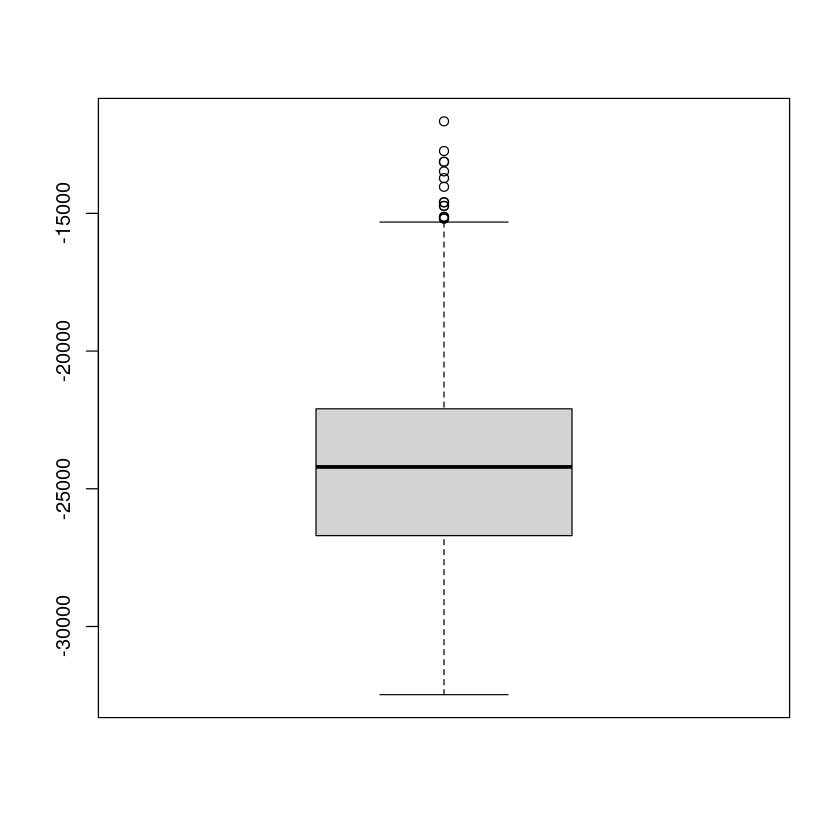

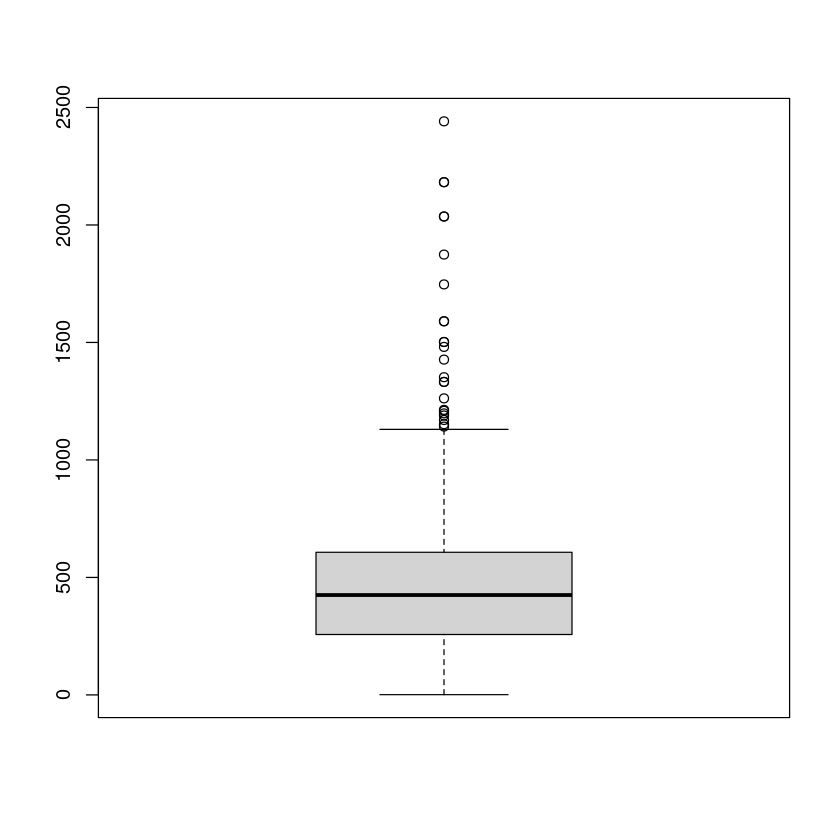

In [34]:
# boxplot(clinical %>% dplyr::select(days_to_birth, days_to_death))
boxplot(clinical$days_to_birth)
boxplot(clinical$days_to_death)

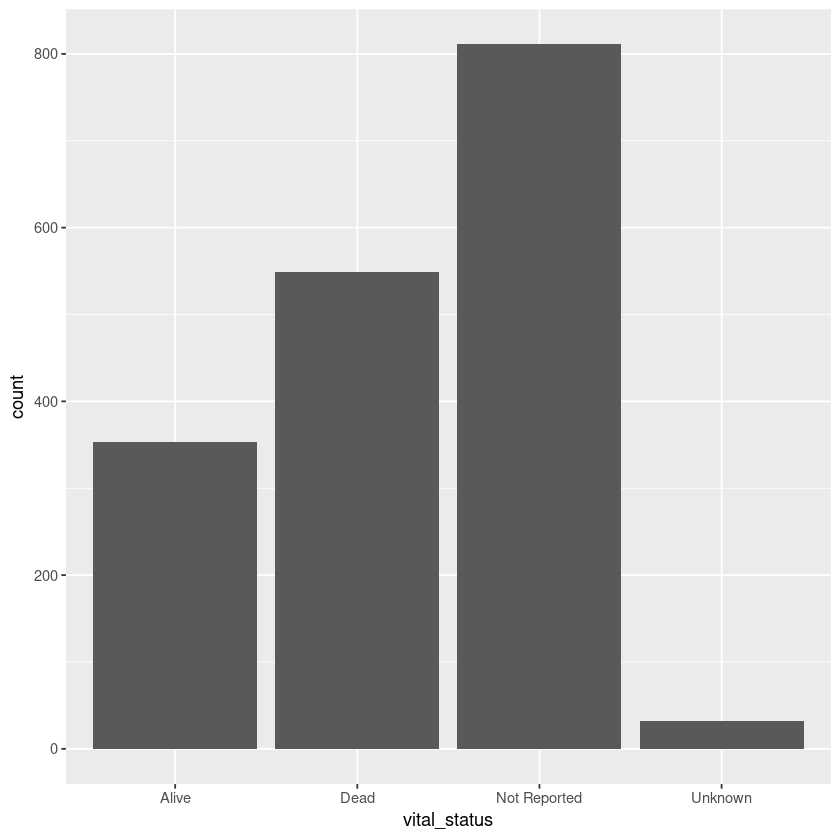

In [35]:
ggplot(clinical, aes(vital_status)) + 
    geom_bar()

Warning message:
“Removed 1346 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1346 rows containing non-finite outside the scale range
(`stat_density()`).”


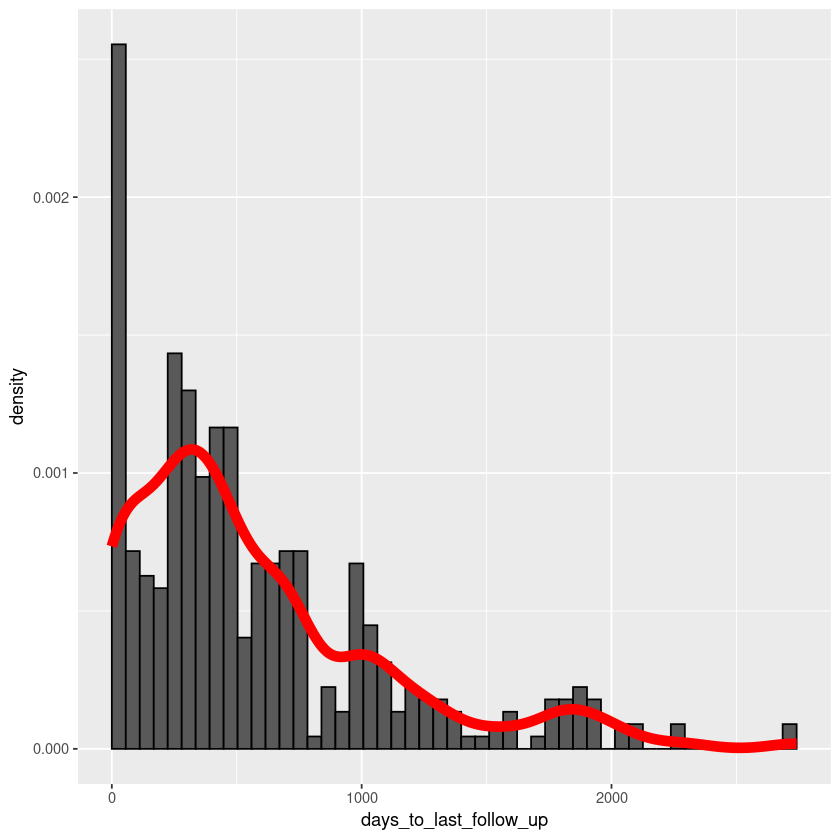

In [36]:
breaks <- seq(from=min(clinical$days_to_last_follow_up, na.rm = TRUE), to=max(clinical$days_to_last_follow_up, na.rm = TRUE), length=50)

ggplot(clinical, aes(x=days_to_last_follow_up, after_stat(density))) +
    geom_histogram(breaks=breaks, colour="black") +
    geom_density(colour="red", linewidth=3)

Warning message:
“Removed 1212 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1212 rows containing non-finite outside the scale range
(`stat_density()`).”


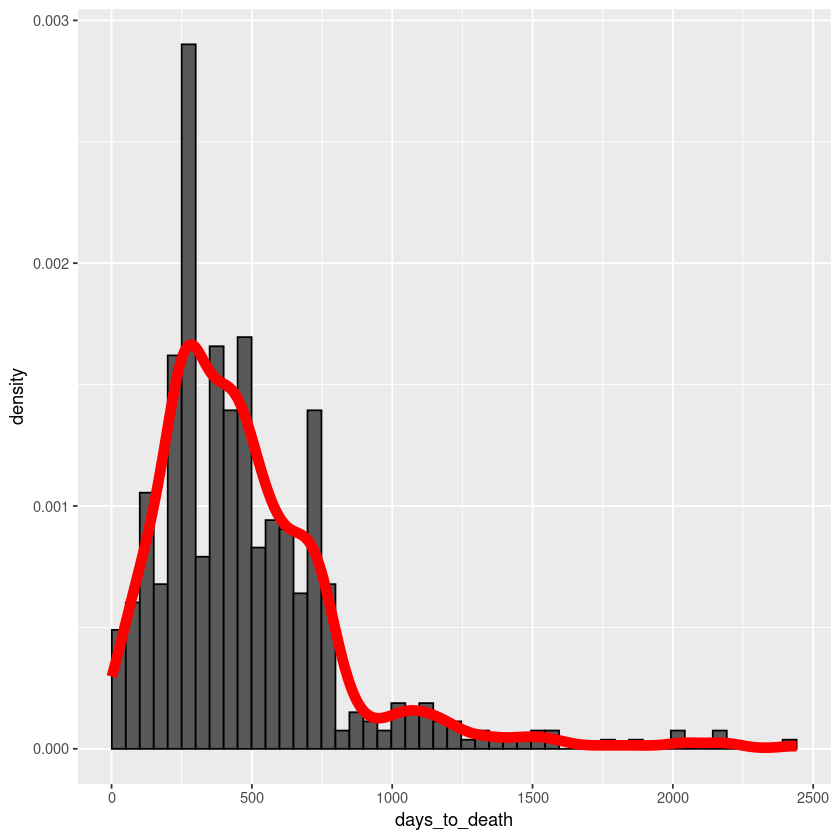

In [37]:
breaks <- seq(from=min(clinical$days_to_death, na.rm = TRUE), to=max(clinical$days_to_death, na.rm = TRUE), length=50)

ggplot(clinical, aes(x=days_to_death, after_stat(density))) +
    geom_histogram(breaks=breaks, colour="black") +
    geom_density(colour="red", linewidth=3)

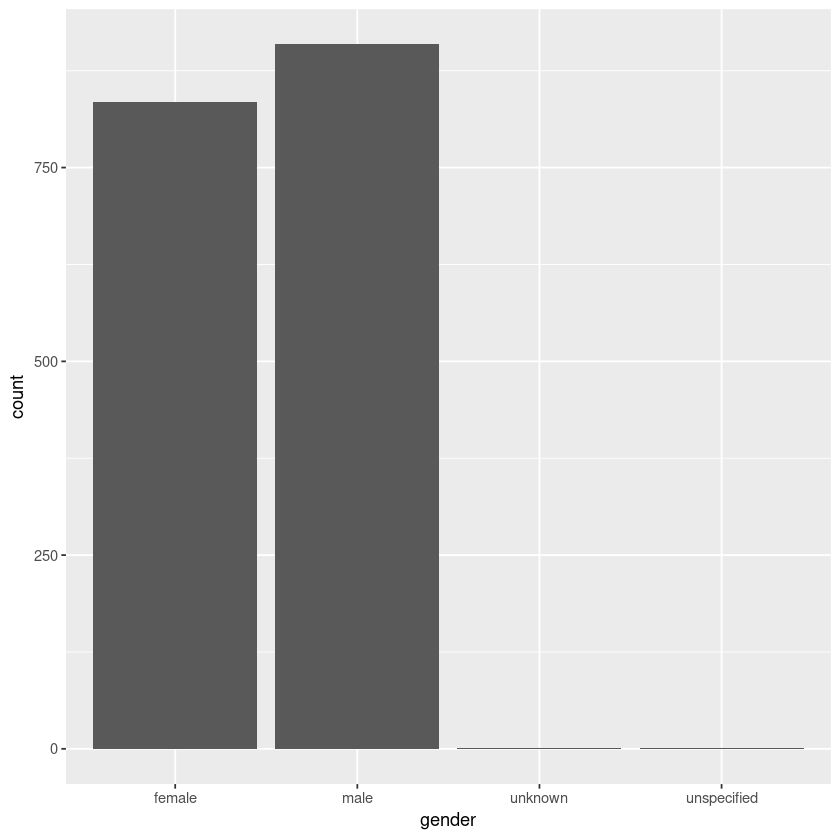

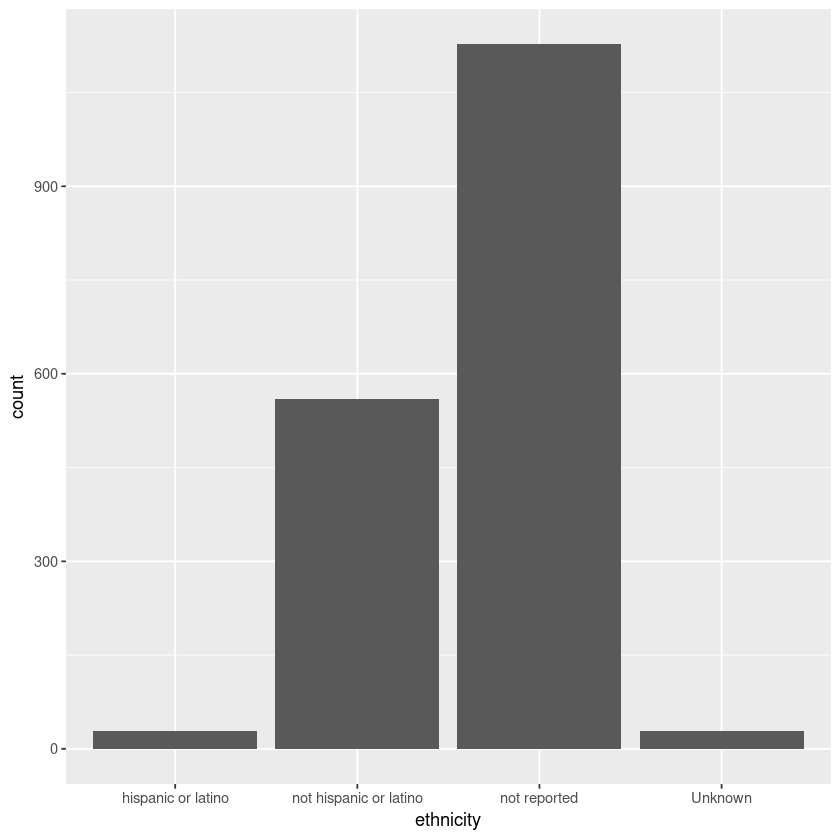

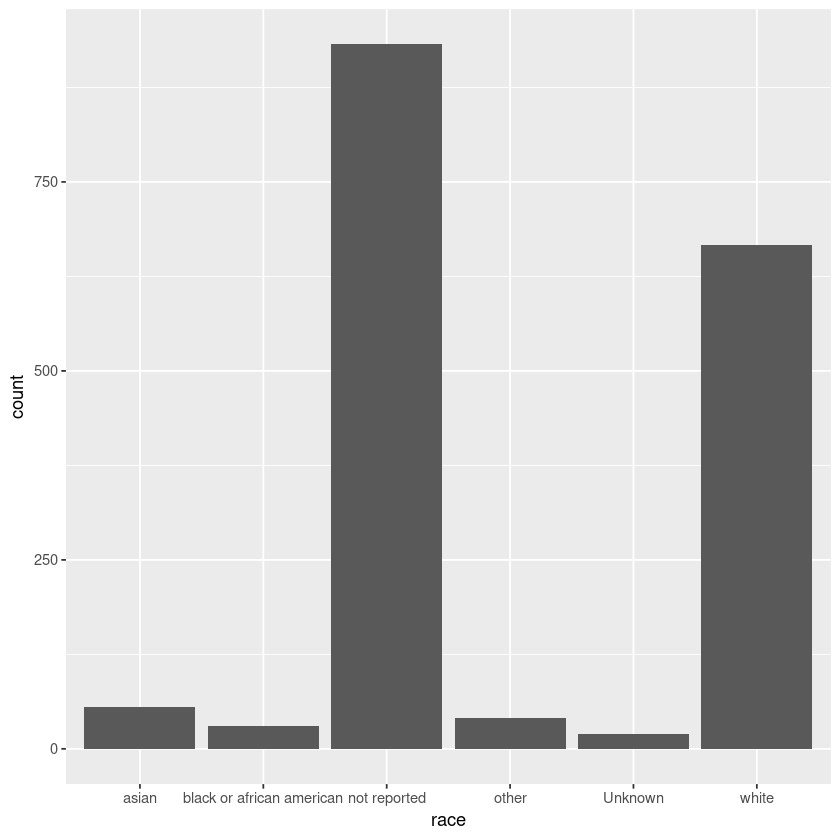

In [38]:
ggplot(clinical, aes(gender)) + geom_bar()
ggplot(clinical, aes(ethnicity)) + geom_bar()
ggplot(clinical, aes(race)) + geom_bar()

## Анализ выживаемости

In [39]:
pancreas$deceased <- ifelse(pancreas$vital_status == "Alive", FALSE, TRUE)  # умершие

In [40]:
# создадим переменную overall_survival (общая выживаемость),
# которая равна days_to_death (дней до смерти) для умерших пациентов
# и days_to_last_follow_up (дней до последнего наблюдения) для пациентов, которые всё ещё живы
pancreas$overall_survival <- ifelse(pancreas$vital_status == "Alive",
                                    pancreas$days_to_last_follow_up,
                                    pancreas$days_to_death)

In [41]:
# возрастные группы
pancreas <- pancreas %>%
    mutate(
           age_group = factor(case_when(age_at_index < 50 ~ "< 50",
                                        age_at_index >= 50 & age_at_index < 60 ~ "50 - 60",
                                        age_at_index >= 60 & age_at_index < 70 ~ "60 - 70",
                                        age_at_index >= 70 & age_at_index < 80 ~ "70 - 80",
                                        age_at_index >= 80 ~ "> 80"))
          ) %>%
    relocate(age_group, .before = "age_at_index")

### Проверка гипотез

Для проверки гипотез о влиянии различных переменных на выживаемость проведём несколько статистических тестов с помощью функции `survival::survdiff`.

In [42]:
# пол
dif_gender <- survdiff(Surv(overall_survival, deceased) ~ gender, data = pancreas)
dif_gender
if (dif_gender$pvalue < alpha) {
  print("отвергаем гипотезу H0 => переменные оказывают влияние на выживаемость")
} else {
  print("не можем отвергнуть гипотезу H0 => переменные не влияют на выживаемость")
}

Call:
survdiff(formula = Surv(overall_survival, deceased) ~ gender, 
    data = pancreas)

n=737, 1008 observations deleted due to missingness.

                N Observed Expected (O-E)^2/E (O-E)^2/V
gender=female 350      268      236      4.28      7.88
gender=male   387      265      297      3.41      7.88

 Chisq= 7.9  on 1 degrees of freedom, p= 0.005 

[1] "отвергаем гипотезу H0 => переменные оказывают влияние на выживаемость"


In [43]:
# этническая принадлежность
dif_ethni <- survdiff(Surv(overall_survival, deceased) ~ ethnicity, data = pancreas)
dif_ethni
if (dif_ethni$pvalue < alpha) {
  print("отвергаем гипотезу H0 => переменные оказывают влияние на выживаемость")
} else {
  print("не можем отвергнуть гипотезу H0 => переменные не влияют на выживаемость")
}

Call:
survdiff(formula = Surv(overall_survival, deceased) ~ ethnicity, 
    data = pancreas)

n=737, 1008 observations deleted due to missingness.

                                   N Observed Expected (O-E)^2/E (O-E)^2/V
ethnicity=hispanic or latino      17       12    18.39     2.221     2.378
ethnicity=not hispanic or latino 439      299   306.99     0.208     0.501
ethnicity=not reported           270      211   200.26     0.576     0.943
ethnicity=Unknown                 11       11     7.36     1.804     1.873

 Chisq= 5  on 3 degrees of freedom, p= 0.2 

[1] "не можем отвергнуть гипотезу H0 => переменные не влияют на выживаемость"


In [44]:
# раса
dif_race <- survdiff(Surv(overall_survival, deceased) ~ race, data = pancreas)
dif_race
if (dif_race$pvalue < alpha) {
  print("отвергаем гипотезу H0 => переменные оказывают влияние на выживаемость")
} else {
  print("не можем отвергнуть гипотезу H0 => переменные не влияют на выживаемость")
}

Call:
survdiff(formula = Surv(overall_survival, deceased) ~ race, data = pancreas)

n=737, 1008 observations deleted due to missingness.

                                 N Observed Expected (O-E)^2/E (O-E)^2/V
race=asian                      54       38    51.51    3.5450    4.0323
race=black or african american  24       19    14.53    1.3730    1.4372
race=not reported               65       62    38.71   14.0089   15.6405
race=other                      41       33    36.38    0.3143    0.3471
race=Unknown                     6        6     5.49    0.0479    0.0494
race=white                     547      375   386.37    0.3347    1.2441

 Chisq= 20.5  on 5 degrees of freedom, p= 0.001 

[1] "отвергаем гипотезу H0 => переменные оказывают влияние на выживаемость"


In [45]:
# тип лечения
dif_treat <- survdiff(Surv(overall_survival, deceased) ~ treatment_type, data = pancreas)
dif_treat
if (dif_treat$pvalue < alpha) {
  print("отвергаем гипотезу H0 => переменные оказывают влияние на выживаемость")
} else {
  print("не можем отвергнуть гипотезу H0 => переменные не влияют на выживаемость")
}

Call:
survdiff(formula = Surv(overall_survival, deceased) ~ treatment_type, 
    data = pancreas)

n=556, 1189 observations deleted due to missingness.

                                                             N Observed
treatment_type=Chemotherapy                                 98       98
treatment_type=Immunotherapy (Including Vaccines)           19       19
treatment_type=Pharmaceutical Therapy, NOS                 188      103
treatment_type=Radiation Therapy, NOS                      206      121
treatment_type=Radiation, 2D Conventional                    1        1
treatment_type=Radiation, Intensity-Modulated Radiotherapy   1        1
treatment_type=Surgery, NOS                                 22       22
treatment_type=Targeted Molecular Therapy                   21       21
                                                           Expected (O-E)^2/E
treatment_type=Chemotherapy                                  54.910    33.814
treatment_type=Immunotherapy (Including Vac

[1] "отвергаем гипотезу H0 => переменные оказывают влияние на выживаемость"


In [46]:
# злоупотребление алкоголем
dif_alco.int <- survdiff(Surv(overall_survival, deceased) ~ alcohol_intensity, data = pancreas)
dif_alco.int
if (dif_alco.int$pvalue < alpha) {
  print("отвергаем гипотезу H0 => переменные оказывают влияние на выживаемость")
} else {
  print("не можем отвергнуть гипотезу H0 => переменные не влияют на выживаемость")
}

Call:
survdiff(formula = Surv(overall_survival, deceased) ~ alcohol_intensity, 
    data = pancreas)

n=362, 1383 observations deleted due to missingness.

                                        N Observed Expected (O-E)^2/E (O-E)^2/V
alcohol_intensity=Drinker              39       39     43.8     0.533     0.665
alcohol_intensity=Lifelong Non-Drinker 75       63     71.3     0.961     1.293
alcohol_intensity=Non-Drinker          93       91     71.0     5.641     7.741
alcohol_intensity=Occasional Drinker   93       81    106.0     5.885     9.263
alcohol_intensity=Unknown              62       54     35.9     9.092    10.826

 Chisq= 23.8  on 4 degrees of freedom, p= 9e-05 

[1] "отвергаем гипотезу H0 => переменные оказывают влияние на выживаемость"


In [47]:
# возрастная группа
dif_age.grp <- survdiff(Surv(overall_survival, deceased) ~ age_group, data = pancreas)
dif_age.grp
if (dif_age.grp$pvalue < alpha) {
  print("отвергаем гипотезу H0 => переменные оказывают влияние на выживаемость")
} else {
  print("не можем отвергнуть гипотезу H0 => переменные не влияют на выживаемость")
}

Call:
survdiff(formula = Surv(overall_survival, deceased) ~ age_group, 
    data = pancreas)

n=370, 1375 observations deleted due to missingness.

                    N Observed Expected (O-E)^2/E (O-E)^2/V
age_group=< 50     40       20     26.0     1.391     1.633
age_group=> 80     34       28     10.7    27.888    30.100
age_group=50 - 60  74       36     43.8     1.393     1.811
age_group=60 - 70 114       56     64.7     1.162     1.769
age_group=70 - 80 108       60     54.8     0.495     0.699

 Chisq= 33.2  on 4 degrees of freedom, p= 1e-06 

[1] "отвергаем гипотезу H0 => переменные оказывают влияние на выживаемость"


**Результаты:**

| переменная | показатель | влияет на выживаемость |
|:---:|:---:|:---:|
| `gender` | пол | да |
| `ethnicity` | этническая принадлежность | нет |
| `race` | раса | да |
| `treatment_type` | тип лечения | да |
| `alcohol_intensity` | злоупотребление алкоголем | да |
| `age_group` | возрастная группа | да |

### Кривые выживаемости

In [48]:
options(repr.plot.width = 16, repr.plot.height = 9)

Call: survfit(formula = Surv(overall_survival, deceased) ~ 1, data = pancreas, 
    conf.int = gamma)

   1008 observations deleted due to missingness 
       n events median 0.95LCL 0.95UCL
[1,] 737    533    494     476     547

Call: survfit(formula = Surv(overall_survival, deceased) ~ 1, data = pancreas, 
    conf.int = gamma)

1008 observations deleted due to missingness 
 time n.risk n.event survival std.err lower 95% CI upper 95% CI
  365    459     221    0.686  0.0176        0.652        0.721

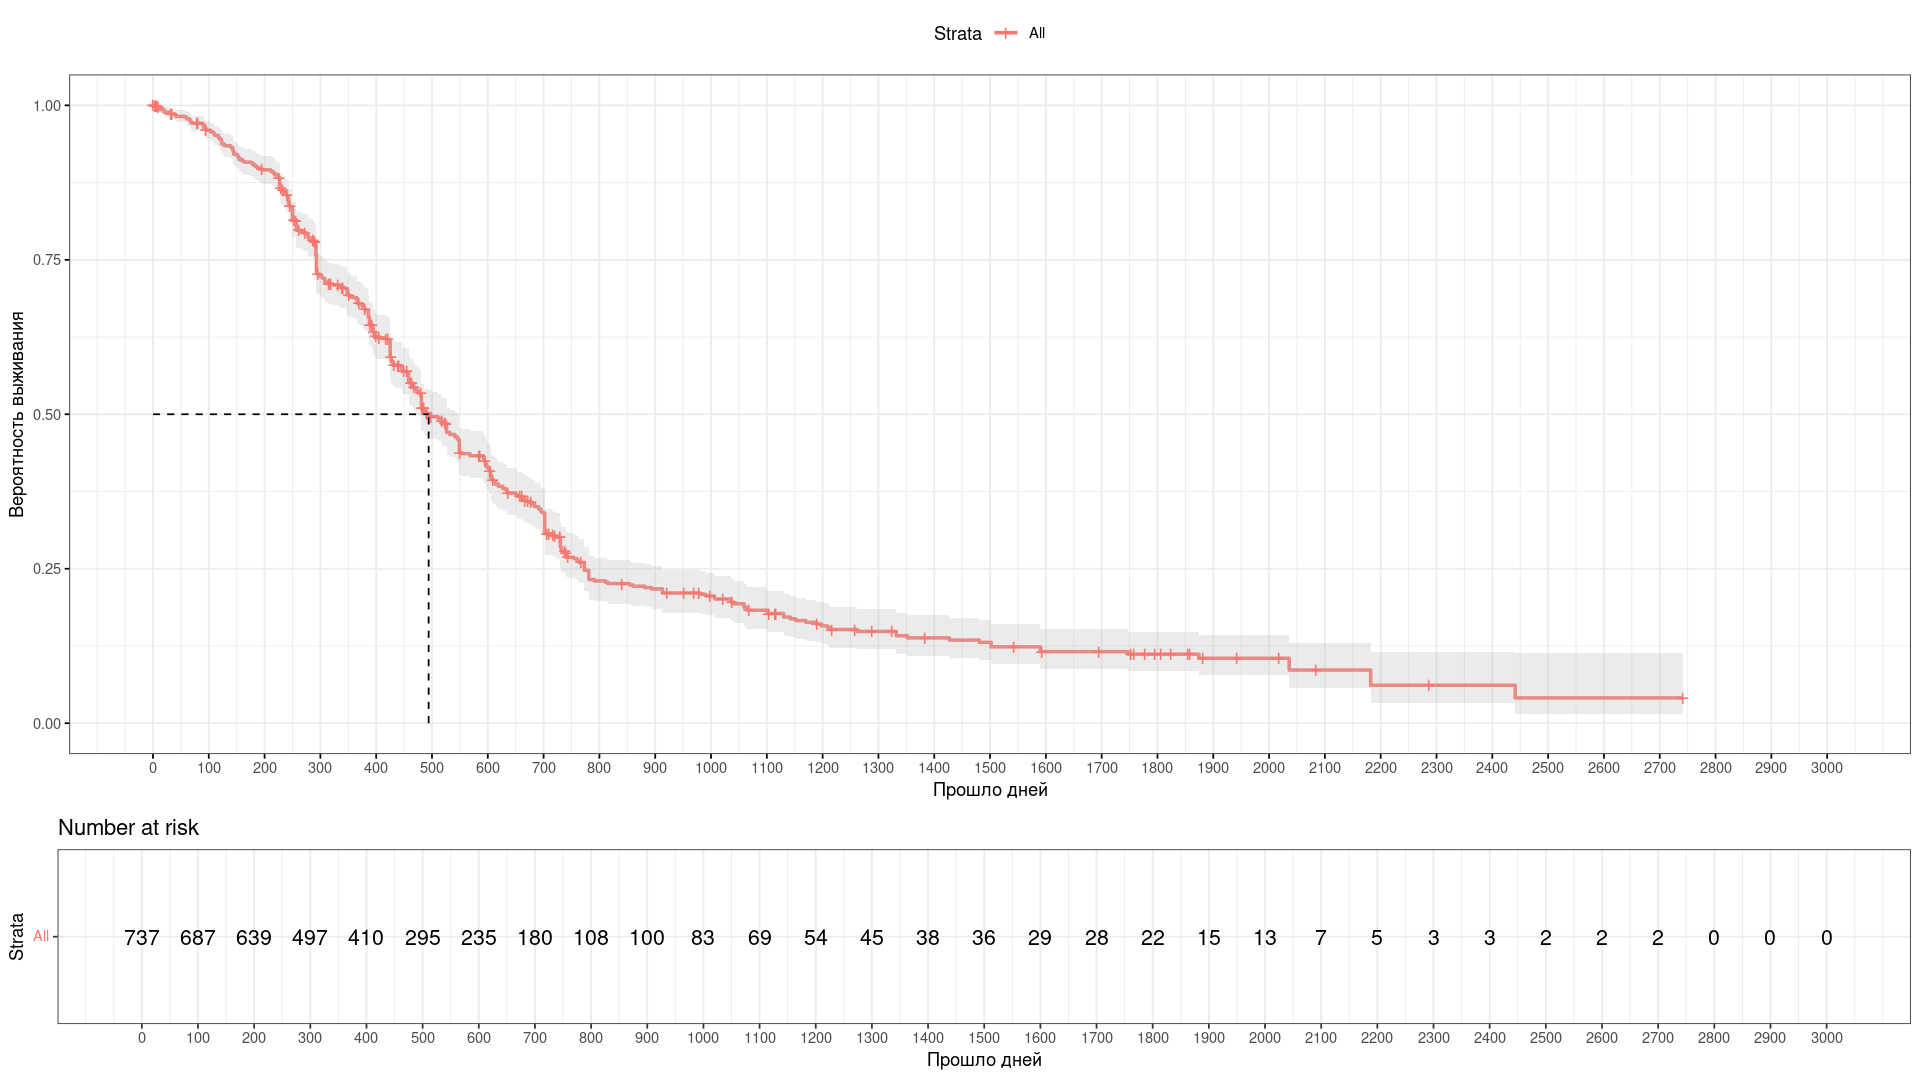

In [49]:
# общая кривая выживаемости для всего набора данных
fit_1 <- survfit2(Surv(overall_survival, deceased) ~ 1, data = pancreas, conf.int = gamma)
fit_1
#fit_1 %>% tbl_survfit(probs = 0.5, label_header = "**Median survival (95% CI)**") %>% as_tibble()
summary(fit_1, times = 365.25)
#fit_1 %>% tbl_survfit(times = 365.25, label_header = "**1-year survival (95% CI)**") %>% as_tibble()

ggsurvplot(fit_1, data = pancreas, pval = FALSE, risk.table = TRUE, conf.int = TRUE, surv.median.line = "hv",
           xlab = "Прошло дней", ylab = "Вероятность выживания", break.time.by = 100,
           ggtheme = theme_bw())

# fit_1 %>%
#     ggsurvfit(linewidth = 1) +
#     add_confidence_interval() +
#     add_risktable(risktable_stats = "n.risk", risktable_group = "auto") +
#     add_quantile(linewidth = 1, linetype = "dashed", alpha = 0.5, y_value = 0.5) +
#     add_quantile(linewidth = 1, linetype = "dotted", alpha = 0.5, x_value = 365.25) +
#     scale_ggsurvfit(x_scales = list(breaks = seq(0, 3100, by = 100))) +
#     labs(x = "Прошло дней", y = "Вероятность выживания")

Call: survfit(formula = Surv(overall_survival, deceased) ~ gender, 
    data = pancreas)

   1008 observations deleted due to missingness 
                n events median 0.95LCL 0.95UCL
gender=female 350    268    446     425     481
gender=male   387    265    599     525     652

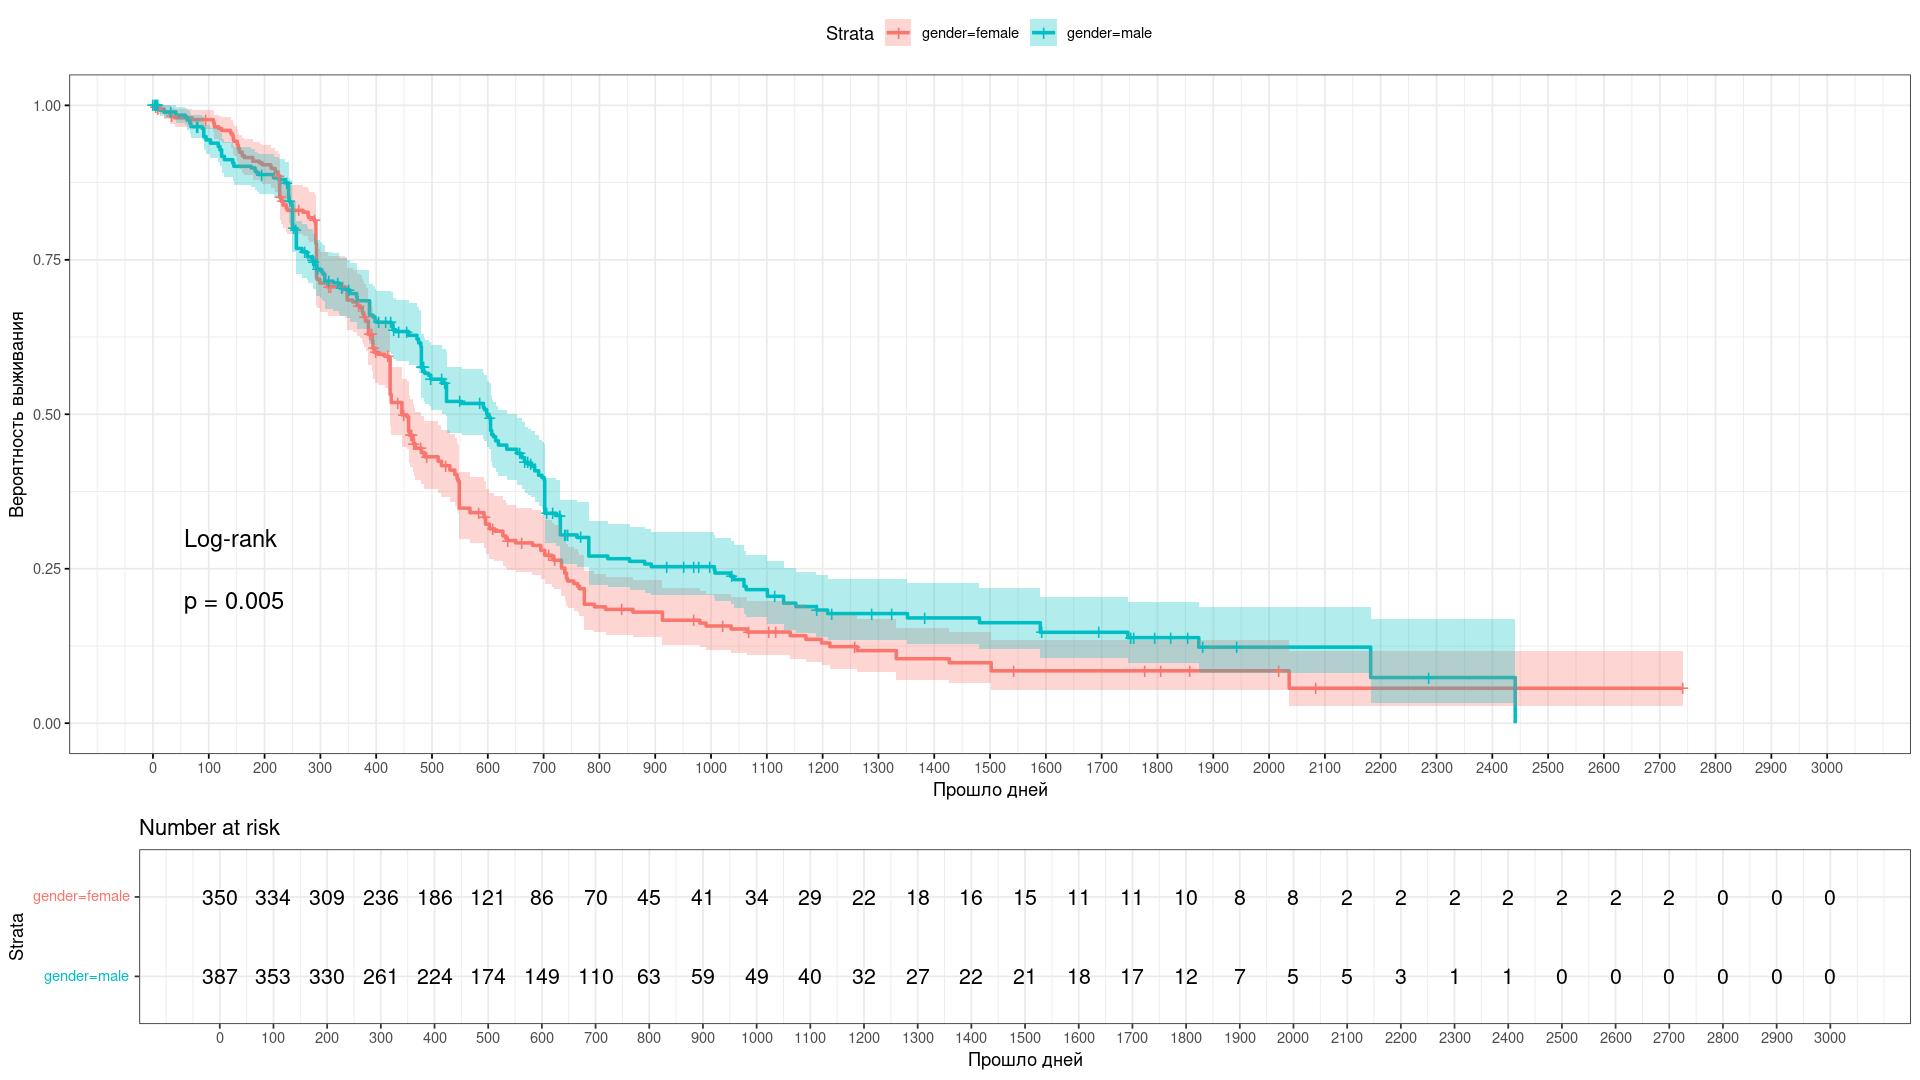

In [50]:
fit_gender <- survfit(Surv(overall_survival, deceased) ~ gender, data = pancreas)
fit_gender
ggsurvplot(fit_gender, data = pancreas,
           pval = TRUE, pval.method = TRUE, risk.table = TRUE, conf.int = TRUE,
           xlab = "Прошло дней", ylab = "Вероятность выживания", break.time.by = 100,
           ggtheme = theme_bw())

Call: survfit(formula = Surv(overall_survival, deceased) ~ ethnicity, 
    data = pancreas)

   1008 observations deleted due to missingness 
                                   n events median 0.95LCL 0.95UCL
ethnicity=hispanic or latino      17     12    605     605      NA
ethnicity=not hispanic or latino 439    299    480     425     568
ethnicity=not reported           270    211    526     458     549
ethnicity=Unknown                 11     11    481      NA      NA

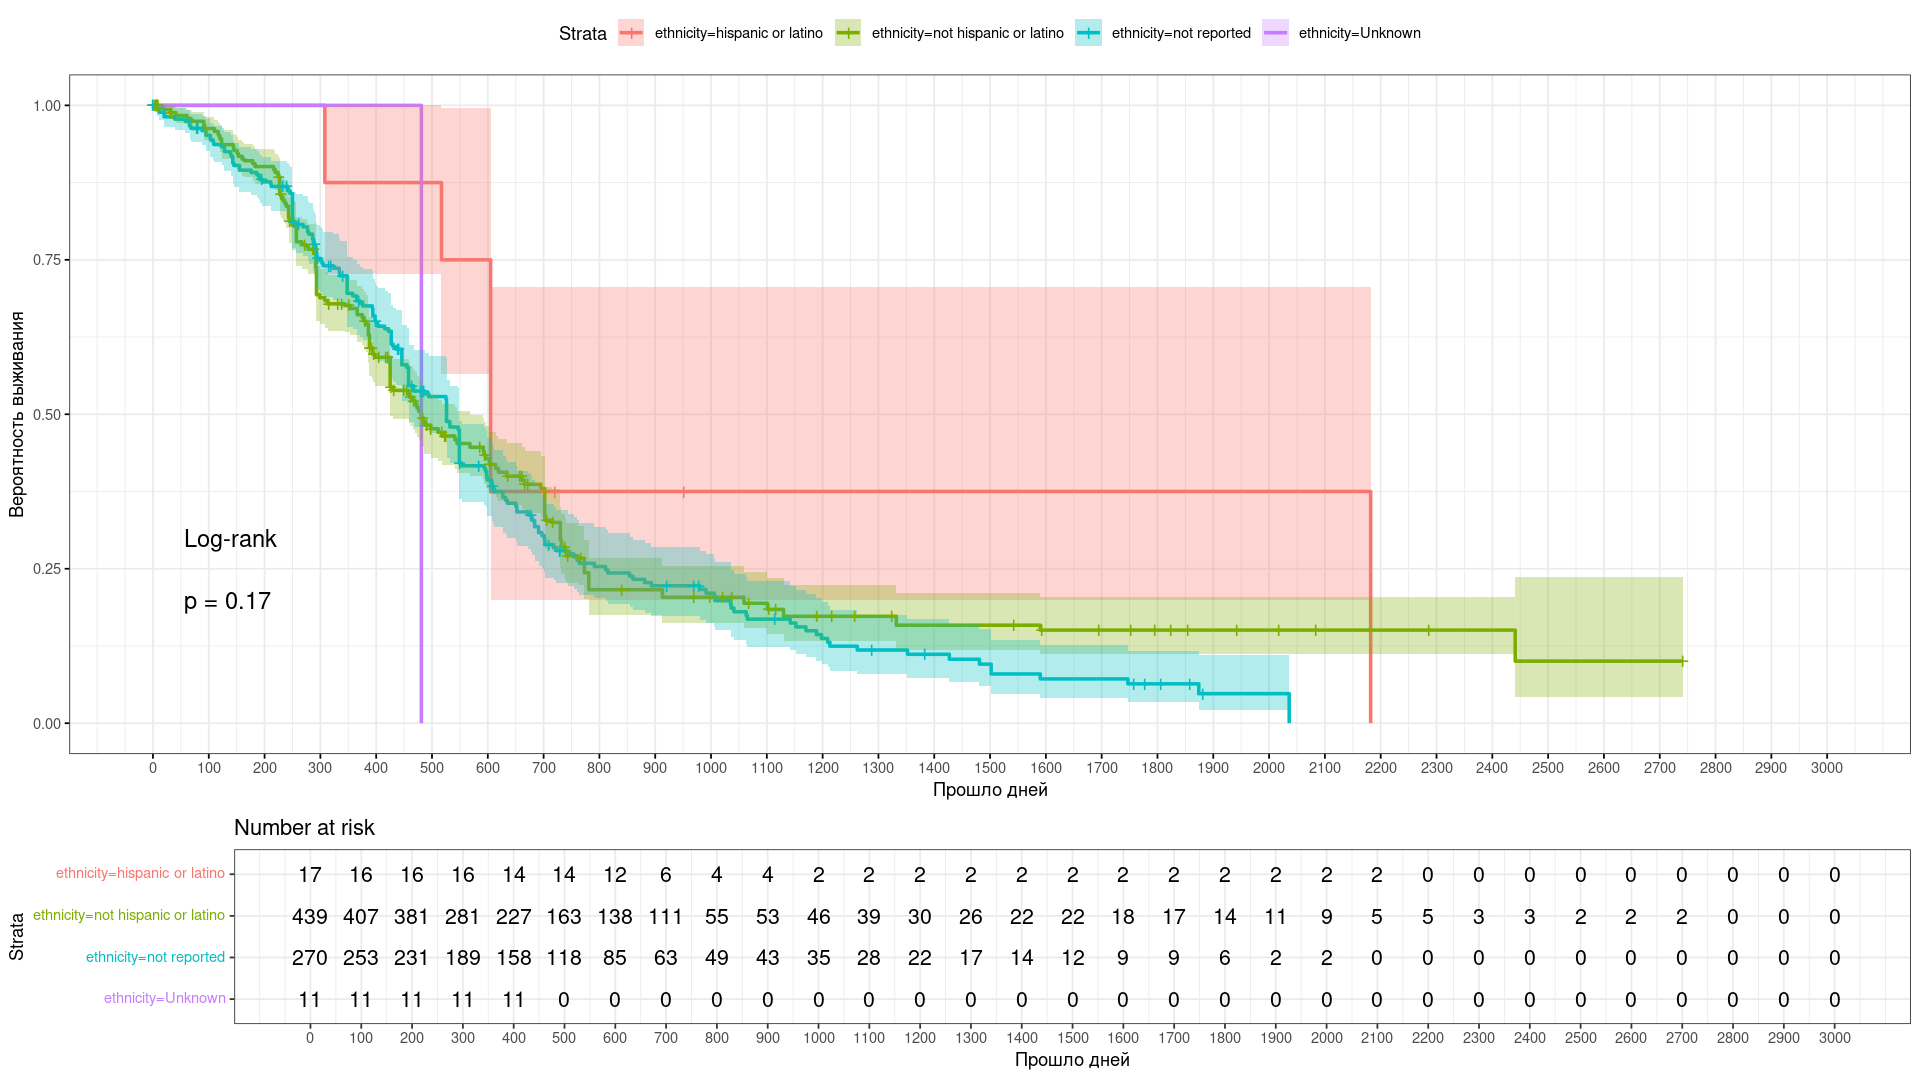

In [51]:
fit_ethnicity <- survfit(Surv(overall_survival, deceased) ~ ethnicity, data = pancreas)
fit_ethnicity
ggsurvplot(fit_ethnicity, data = pancreas,
           pval = TRUE, pval.method = TRUE, risk.table = TRUE, conf.int = TRUE,
           xlab = "Прошло дней", ylab = "Вероятность выживания", break.time.by = 100,
           ggtheme = theme_bw())

Call: survfit(formula = Surv(overall_survival, deceased) ~ race, data = pancreas)

   1008 observations deleted due to missingness 
                                 n events median 0.95LCL 0.95UCL
race=asian                      54     38    781     532    1035
race=black or african american  24     19    393     243      NA
race=not reported               65     62    458     446     526
race=other                      41     33    635     376    1007
race=Unknown                     6      6    605      NA      NA
race=white                     547    375    485     473     593

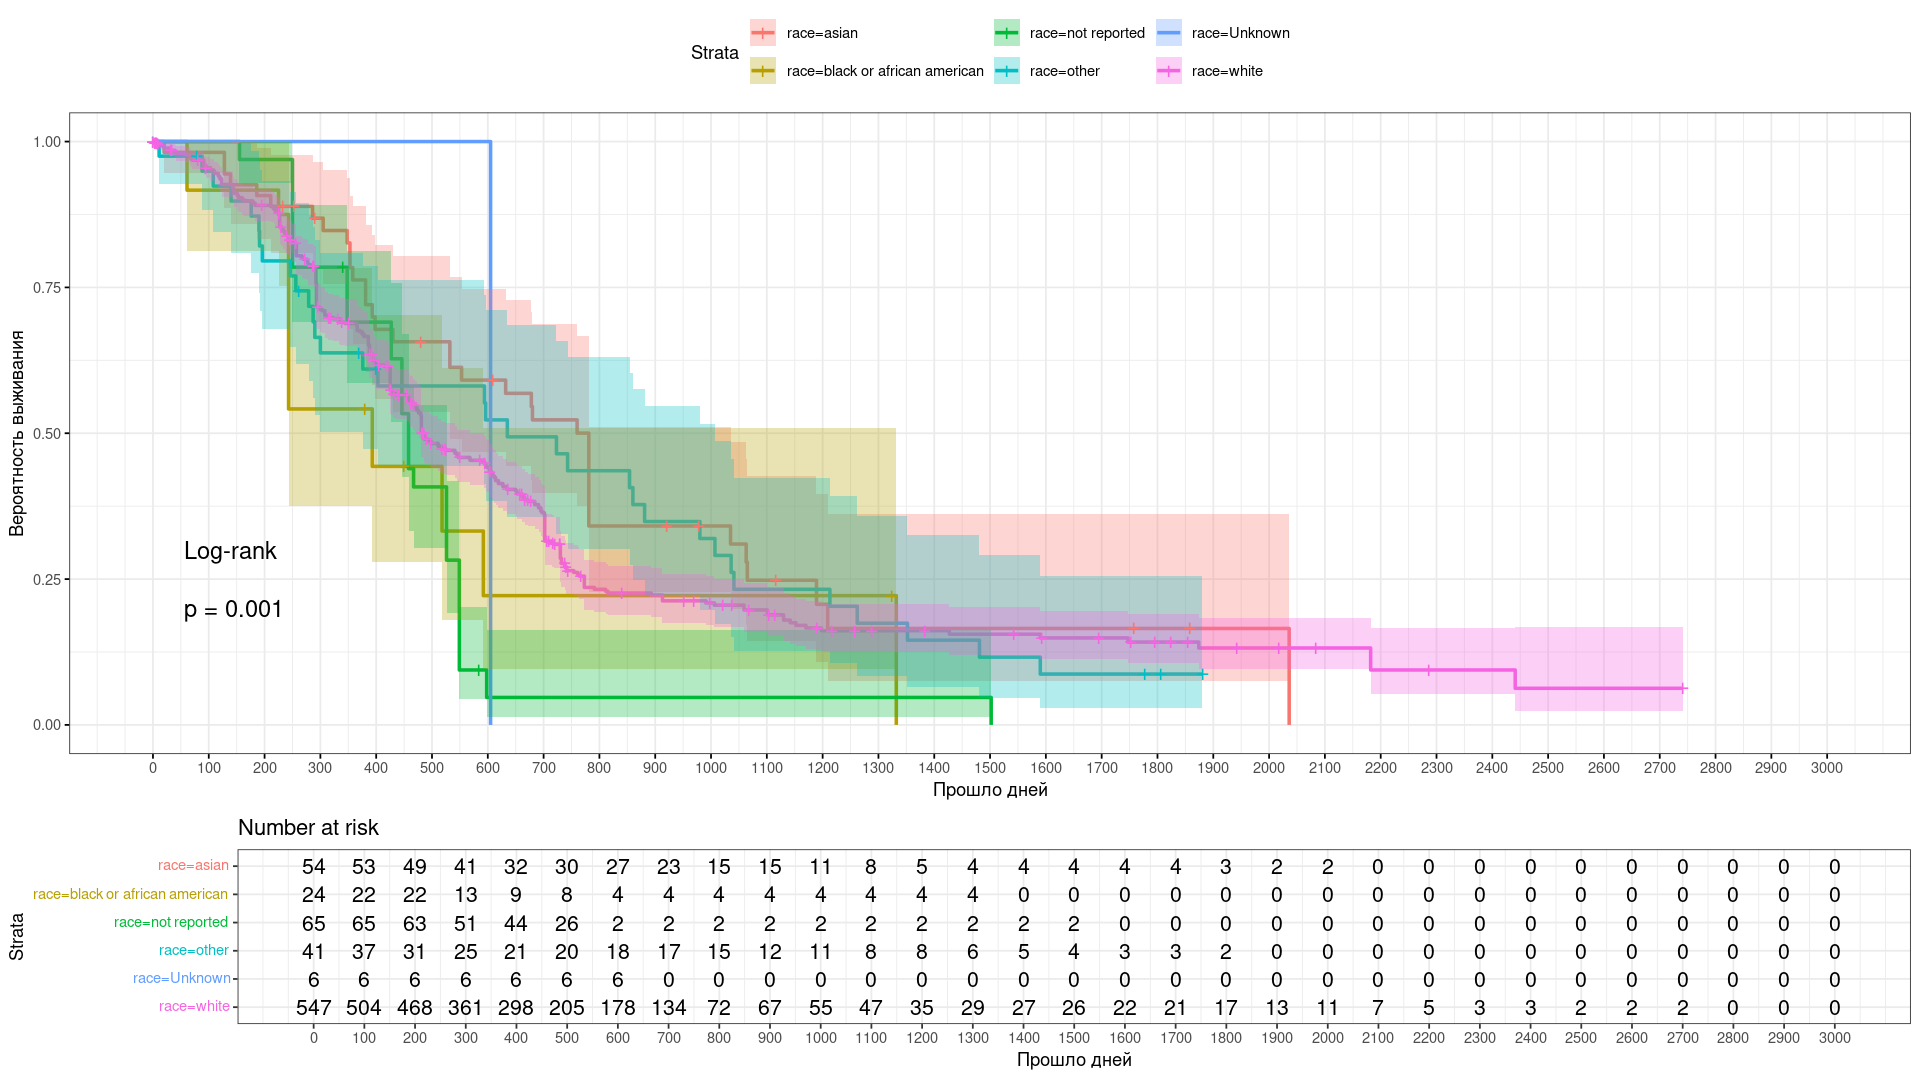

In [52]:
fit_race <- survfit(Surv(overall_survival, deceased) ~ race, data = pancreas)
fit_race
ggsurvplot(fit_race, data = pancreas,
           pval = TRUE, pval.method = TRUE, risk.table = TRUE, conf.int = TRUE,
           xlab = "Прошло дней", ylab = "Вероятность выживания", break.time.by = 100,
           ggtheme = theme_bw())

Call: survfit(formula = Surv(overall_survival, deceased) ~ treatment_type, 
    data = pancreas)

   1189 observations deleted due to missingness 
                                                             n events median
treatment_type=Chemotherapy                                 98     98    388
treatment_type=Immunotherapy (Including Vaccines)           19     19    446
treatment_type=Pharmaceutical Therapy, NOS                 188    103    603
treatment_type=Radiation Therapy, NOS                      206    121    593
treatment_type=Radiation, 2D Conventional                    1      1    348
treatment_type=Radiation, Intensity-Modulated Radiotherapy   1      1    481
treatment_type=Surgery, NOS                                 22     22    426
treatment_type=Targeted Molecular Therapy                   21     21    446
                                                           0.95LCL 0.95UCL
treatment_type=Chemotherapy                                    293     425
treatment_

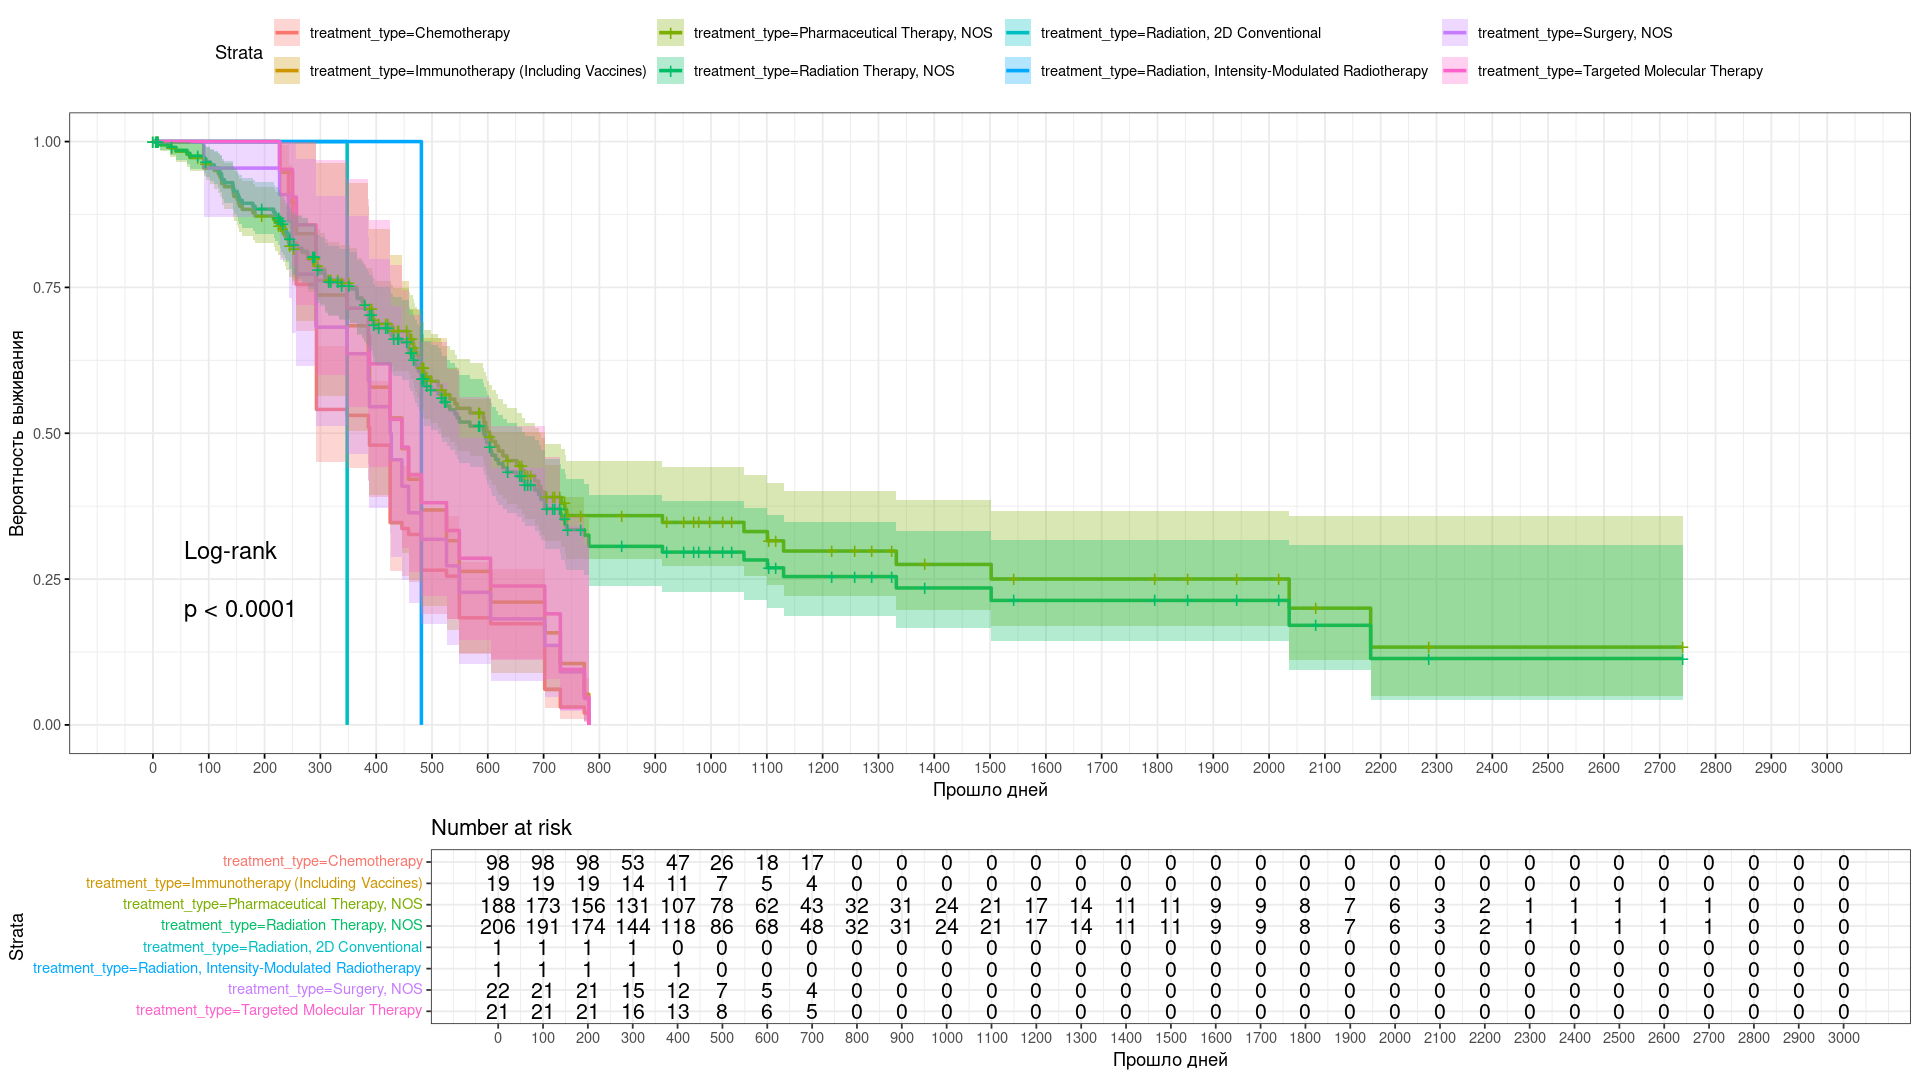

In [53]:
fit_treatment_type <- survfit(Surv(overall_survival, deceased) ~ treatment_type, data = pancreas)
fit_treatment_type
ggsurvplot(fit_treatment_type, data = pancreas,
           pval = TRUE, pval.method = TRUE, risk.table = TRUE, conf.int = TRUE,
           xlab = "Прошло дней", ylab = "Вероятность выживания", break.time.by = 100,
           ggtheme = theme_bw())

Call: survfit(formula = Surv(overall_survival, deceased) ~ alcohol_intensity, 
    data = pancreas)

   1383 observations deleted due to missingness 
                                        n events median 0.95LCL 0.95UCL
alcohol_intensity=Drinker              39     39    702     425     702
alcohol_intensity=Lifelong Non-Drinker 75     63    455     376     650
alcohol_intensity=Non-Drinker          93     91    427     348     458
alcohol_intensity=Occasional Drinker   93     81    605     481     715
alcohol_intensity=Unknown              62     54    292     257     292

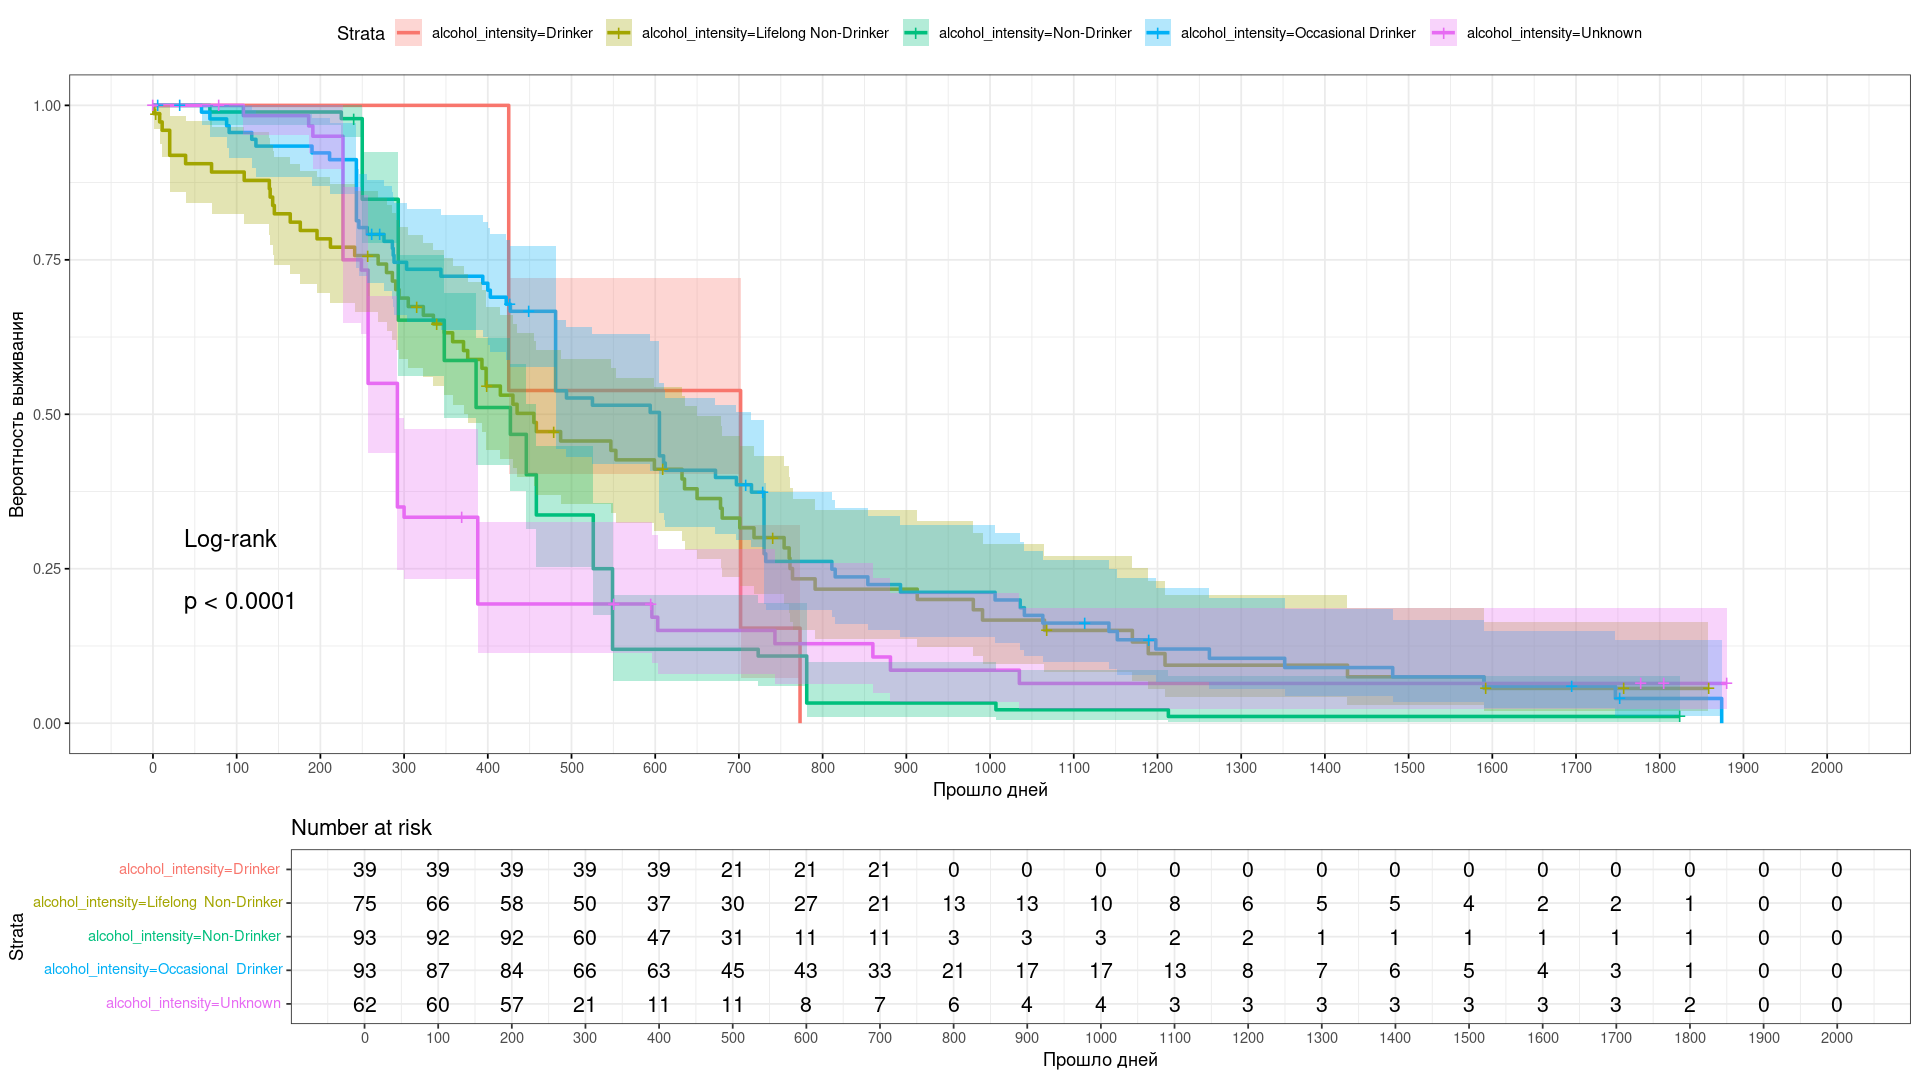

In [54]:
fit_alcohol_intensity <- survfit(Surv(overall_survival, deceased) ~ alcohol_intensity, data = pancreas)
fit_alcohol_intensity
ggsurvplot(fit_alcohol_intensity, data = pancreas,
           pval = TRUE, pval.method = TRUE, risk.table = TRUE, conf.int = TRUE,
           xlab = "Прошло дней", ylab = "Вероятность выживания", break.time.by = 100,
           ggtheme = theme_bw())

Call: survfit(formula = Surv(overall_survival, deceased) ~ age_group, 
    data = pancreas)

   1375 observations deleted due to missingness 
                    n events median 0.95LCL 0.95UCL
age_group=< 50     40     20    913     470      NA
age_group=> 80     34     28    397     244     480
age_group=50 - 60  74     36    607     545      NA
age_group=60 - 70 114     56    634     596    2036
age_group=70 - 80 108     60    619     532     691

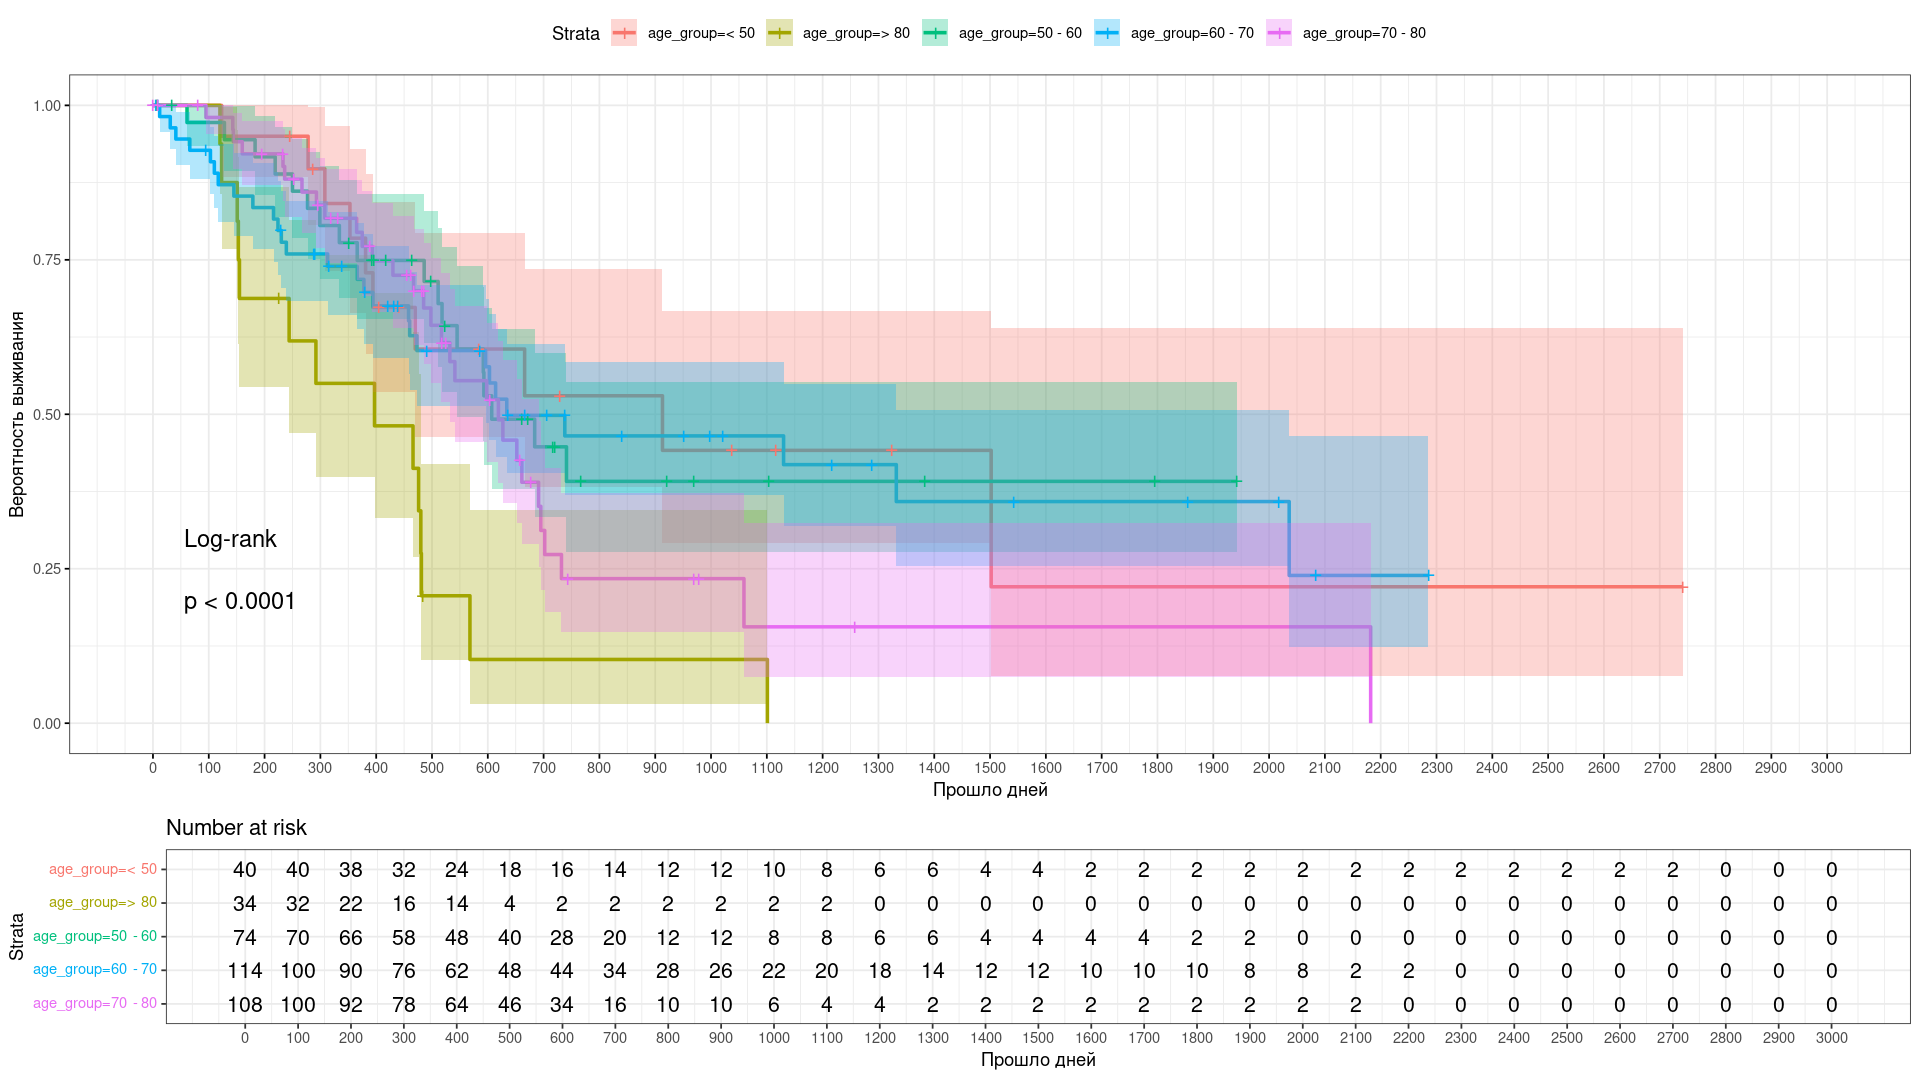

In [55]:
fit_age_group <- survfit(Surv(overall_survival, deceased) ~ age_group, data = pancreas)
fit_age_group
ggsurvplot(fit_age_group, data = pancreas,
           pval = TRUE, pval.method = TRUE, risk.table = TRUE, conf.int = TRUE,
           xlab = "Прошло дней", ylab = "Вероятность выживания", break.time.by = 100,
           ggtheme = theme_bw())

**Выводы:**
- Процент выживших спустя год исследования: 68%
- Медиана выживаемости (наименьшее время выживания, для которого функция выживаемости меньше или равна 0,5.): 494 сут. ~ 1.5 года
- Выживаемость среди мужчин в целом выше, чем выживаемость среди женщин
- Этническая принадлежность не оказывает статистически значимое влияние на выживаемость, а среди рас наибольшая выживаемость у белых и азиатов
- Для типа лечения на результат мог сильно повлиял дисбаланс классов, но, тем не менее, наибольшая выживаемость у тех пациентов, кому была назначена фармацевтическая терапия *по-видимому самая щадящая для организма из представленных*
- Наиболее благоприятный исход лечения - у пациентов моложе 50 лет

Call:
coxph(formula = Surv(overall_survival, deceased) ~ gender + age_group, 
    data = pancreas)

  n= 370, number of events= 200 
   (1375 observations deleted due to missingness)

                    coef exp(coef) se(coef)      z Pr(>|z|)    
gendermale       -0.2252    0.7983   0.1435 -1.570    0.116    
age_group> 80     1.3127    3.7161   0.2993  4.385 1.16e-05 ***
age_group50 - 60  0.1191    1.1265   0.2821  0.422    0.673    
age_group60 - 70  0.1365    1.1463   0.2614  0.522    0.602    
age_group70 - 80  0.4282    1.5346   0.2624  1.632    0.103    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                 exp(coef) exp(-coef) lower .95 upper .95
gendermale          0.7983     1.2526    0.6026     1.058
age_group> 80       3.7161     0.2691    2.0668     6.681
age_group50 - 60    1.1265     0.8877    0.6481     1.958
age_group60 - 70    1.1463     0.8724    0.6867     1.913
age_group70 - 80    1.5346     0.6517    0.9175     2.567

Concordance= 0.

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


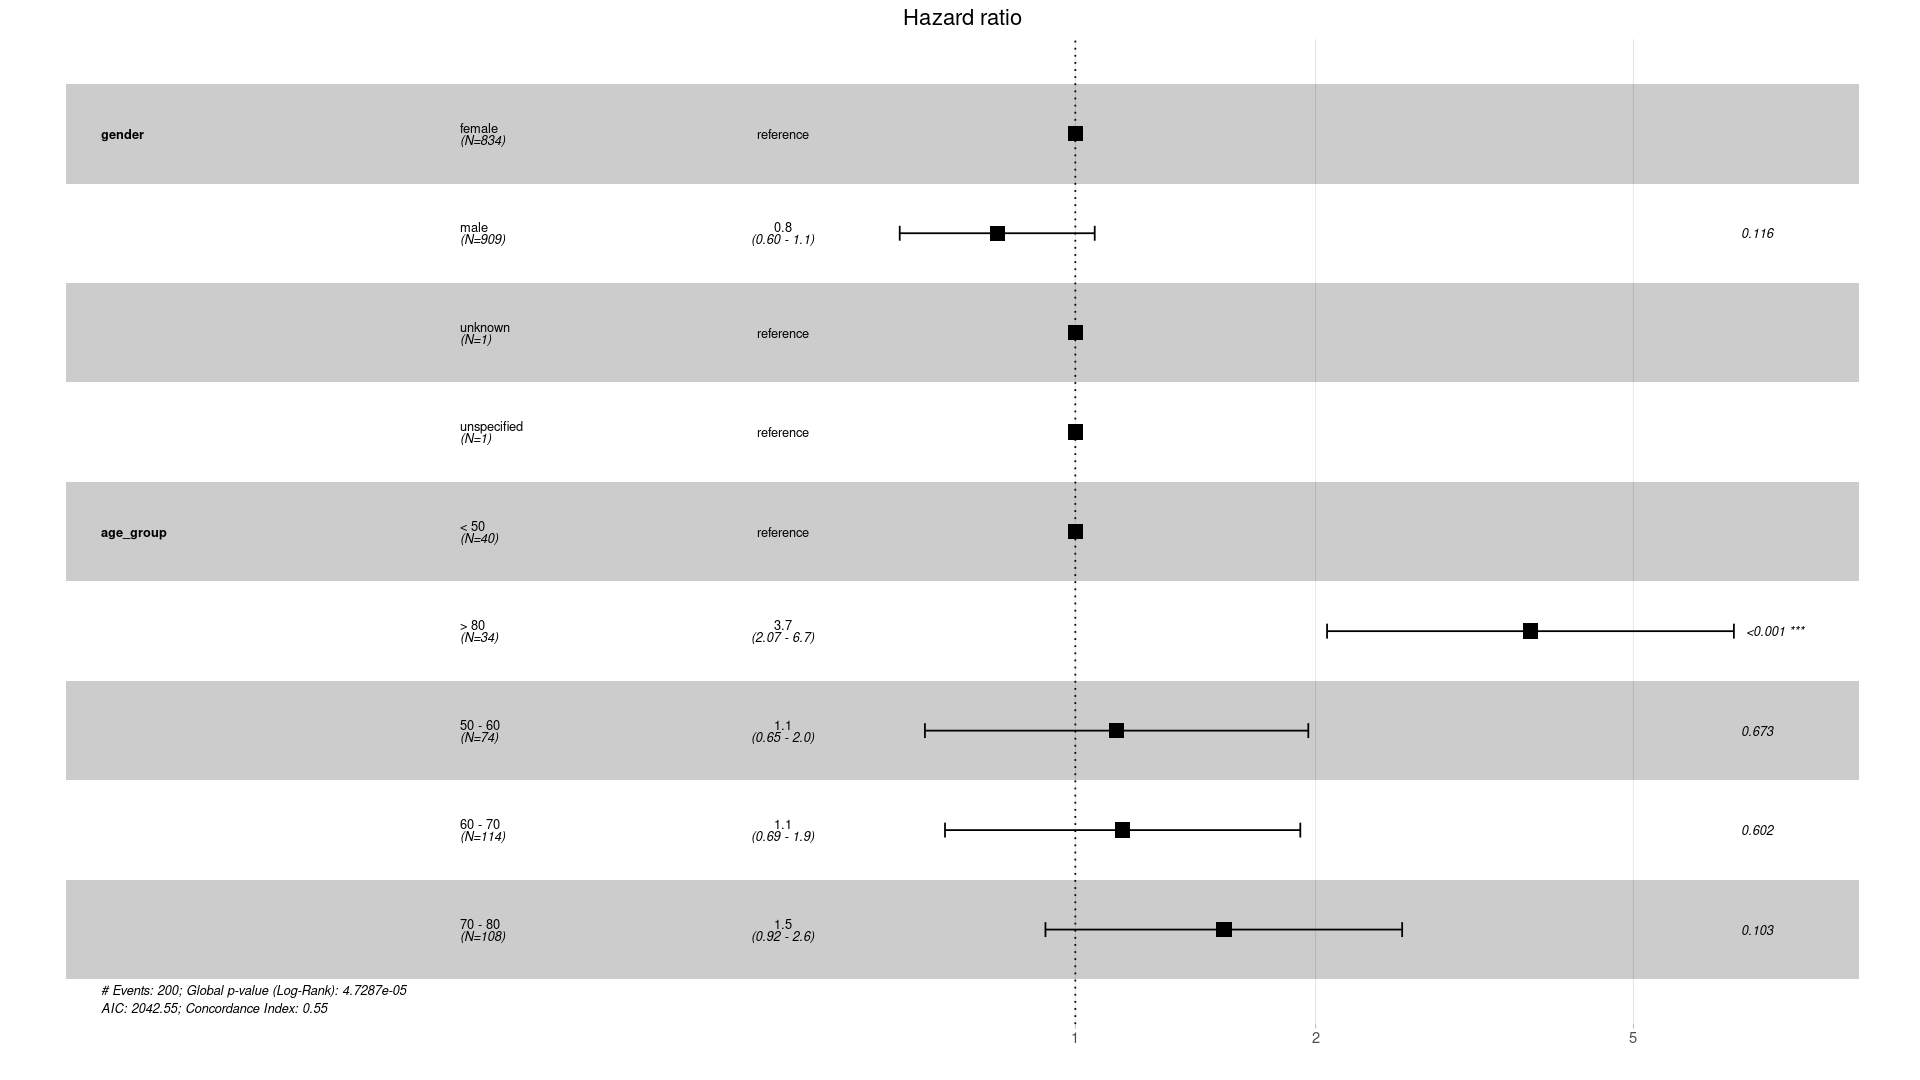

In [56]:
# оценка соотношений рисков для пола и возрастной группы с помощью модели Кокса
cox <- coxph(Surv(overall_survival, deceased) ~ gender + age_group, data = pancreas)
summary(cox)
ggforest(cox)
# cox.zph(cox)

Полученная диаграмма подтверждает сделанные ранее выводы:
- для мужчин риск смерти ниже, чем у женщин
- с возрастом риск смерти увеличивается (*что логично*), особенно велик риск для пожилых пациентов старше 70 лет